## STAGE 1 - EXPLORATORY DATA ANALYSIS (EDA)


# Kelompok 1 - ShipTime Forecasters
- Aisyah Nur Hasanah
- Alvin Kurniawan Hanafie
- Awalsyah Erlangga
- Kevin Munandar



**E-Commerce Shipping Data**<br>
**Deskripsi**<br>
* This notebook is an analysis of shipping data from Shoppedia e-commerce company to determine if packages arrived on time or not<br>

In [ ]:
pip install optbinning

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from imblearn import under_sampling, over_sampling
from sklearn.preprocessing import OrdinalEncoder
from numpy import asarray
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess



print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.23.5
pandas version :  1.5.3
seaborn version :  0.12.2


In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load and Describe Data

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_id = '1BSZHP0pTdFt_DlNH_jcELYoxvNtQ0mx1'
link = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(link)
df.head()


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## 1. Descriptive Statistic

### Info Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


- Dataset berisikan 12 kolom, dengan jumlah 10999 baris.
- Tipe data, dengan nama dan nilai dalam kolomnya sudah sesuai, kecuali ID yang akan diubah menjadi tipe data string.
- Dataset lengkap, tidak ada nilai kosong.
- Variable Reached.on.Time_Y.N akan diubah namanya menjadi Delivered_on_Time untuk agar lebih intuitif dan sesuai dengan business metric yang akan digunakan.  


In [ ]:
#ubah data type id ke string
df['ID']=df['ID'].astype(str)
df.rename(columns = {'Reached.on.Time_Y.N': 'Delivered_on_Time'}, inplace = True)
print(df.dtypes)

ID                     object
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Delivered_on_Time       int64
dtype: object


In [ ]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Delivered_on_Time      0
dtype: int64

In [ ]:
df.duplicated().any()

False

Tidak ada data kosong dan data duplikat.

### Deskripsi Statistik Dataset

In [ ]:
numerical = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Delivered_on_Time']
categorical = ['ID', 'Warehouse_block', 'Mode_of_Shipment','Product_importance','Gender']

In [ ]:
df[numerical].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Delivered_on_Time
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


- Semua nilai variable numeric (min/max) masuk akal.
- Terdapat perbedaan yang cukup jauh antara nilai mean dan median pada feature Prior_purchases, Discount_offered, dimana nilai mean lebih besar dari nilai mediannya. Perbedaan nilai mean dan median variable Discount_offered cukup jauh (13.37 dan 7.00).
- Nilai mean dari Weight_in_gms lebih kecil dari nilai mediannya.
- Terdapat hal unik dimana setiap transaksi memiliki minimal 2 customer care calls.
- Untuk nilai target (Delivered_on_Time), nilai 0 menunjukkan pengiriman barang tepat waktu, dan nilai 1 menunjukkan pengiriman barang yang tidak tepat waktu.

### Jumlah nilai unik per variable numerik

In [ ]:
for col in numerical:
    print(f'Total nilai unik pada {col} :')
    print(df[col].value_counts())
    print()
    print(f'Total persentase nilai unik pada {col} :')
    print(round(df[col].value_counts(normalize = True)*100,2))
    print()

Total nilai unik pada Customer_care_calls :
4    3557
3    3217
5    2328
6    1013
2     638
7     246
Name: Customer_care_calls, dtype: int64

Total persentase nilai unik pada Customer_care_calls :
4    32.34
3    29.25
5    21.17
6     9.21
2     5.80
7     2.24
Name: Customer_care_calls, dtype: float64

Total nilai unik pada Customer_rating :
3    2239
1    2235
4    2189
5    2171
2    2165
Name: Customer_rating, dtype: int64

Total persentase nilai unik pada Customer_rating :
3    20.36
1    20.32
4    19.90
5    19.74
2    19.68
Name: Customer_rating, dtype: float64

Total nilai unik pada Cost_of_the_Product :
245    110
257    109
260    106
254    101
264    100
      ... 
107      5
99       5
120      5
96       5
122      4
Name: Cost_of_the_Product, Length: 215, dtype: int64

Total persentase nilai unik pada Cost_of_the_Product :
245    1.00
257    0.99
260    0.96
254    0.92
264    0.91
       ... 
107    0.05
99     0.05
120    0.05
96     0.05
122    0.04
Name: Cost_of

- Customer care calls paling banyak pada angka 4 (32.34%) dan angka 3 (29.25%).
- Nilai rating 1 - 5 cenderung mendapat angka yang sama sekitar 20%.
- Prior_purchase terbanyak pada angka 3 dengan persentase 35.96% dan angka 2 dengan persentase (23.63%).
- Kebanyakan diskon yang diberikan di bawah 10%.
- Perbandingan target Delivered_on_Time cukup seimbang, dengan perbandingan persentase 59.67% dan 40.33%, sehingga tidak terjadi permasalahan class imbalance.

In [ ]:
df[categorical].describe()

,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999,10999
unique,10999,5,3,3,2
top,1,F,Ship,low,F
freq,1,3666,7462,5297,5545


- Semua nilai ID bersifat unique, sehingga tidak ada duplikat dalam ID. Kolom ID tidak diikutkan dalam Exploratory Data Analysis karena tidak memengaruhi dataset.

### Jumlah nilai unik per variable kategorikal

In [ ]:
categorical = ['Warehouse_block', 'Mode_of_Shipment','Product_importance','Gender']

In [ ]:
for col in categorical:
    print(f'Total nilai unik pada {col} :')
    print(df[col].value_counts())
    print()
    print(f'Total persentase nilai unik pada {col} :')
    print(round(df[col].value_counts(normalize = True)*100,2))
    print()


Total nilai unik pada Warehouse_block :
F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64

Total persentase nilai unik pada Warehouse_block :
F    33.33
D    16.67
A    16.67
B    16.67
C    16.67
Name: Warehouse_block, dtype: float64

Total nilai unik pada Mode_of_Shipment :
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64

Total persentase nilai unik pada Mode_of_Shipment :
Ship      67.84
Flight    16.16
Road      16.00
Name: Mode_of_Shipment, dtype: float64

Total nilai unik pada Product_importance :
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64

Total persentase nilai unik pada Product_importance :
low       48.16
medium    43.22
high       8.62
Name: Product_importance, dtype: float64

Total nilai unik pada Gender :
F    5545
M    5454
Name: Gender, dtype: int64

Total persentase nilai unik pada Gender :
F    50.41
M    49.59
Name: Gender, dtype: float64



- Block F pada Variable Warehouse_block paling banyak dengan persentase 33.33%.
- Ship menjadi metode paling banyak (mendominasi) dalam variable Mode_of_Shipment dengan persentase 67.84%.
- Produk dengan tingkat importance low paling banyak pada variable Product_importance dengan persentase 48.16%. Produk dengan importance high  paling sedikit dengan persentase 8.62%.
- Persebaran gender Female dan Male cenderung merata dengan perbandingan persentase 50.41% dan 49.59%.
- Tidak ada nilai feature yang jumlahnya terlalu timpang, sehingga feature categorical masih dapat digunakan untuk Exploratory Data Analysis.

# 2. Univariate Analysis

### Sebaran Feature Numerik

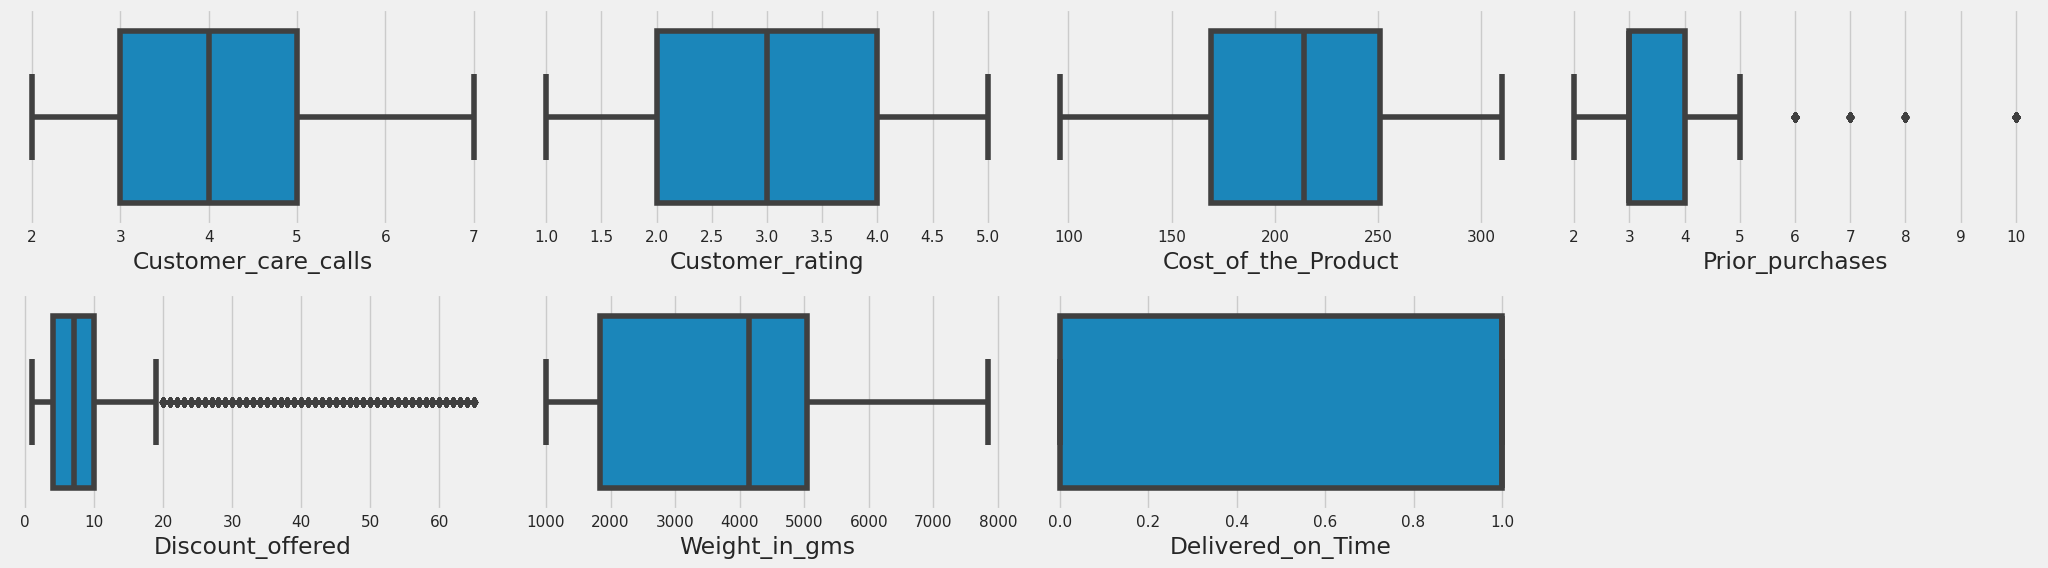

In [ ]:
#Boxplot Features untuk mengecek outlier
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=df[numerical[i]])
    plt.tight_layout()

- Variable Prior_purchases dan Discount_offered memiliki nilai outlier, terutama pada variable Discount_offered yang memiliki cukup banyak nilai outlier.

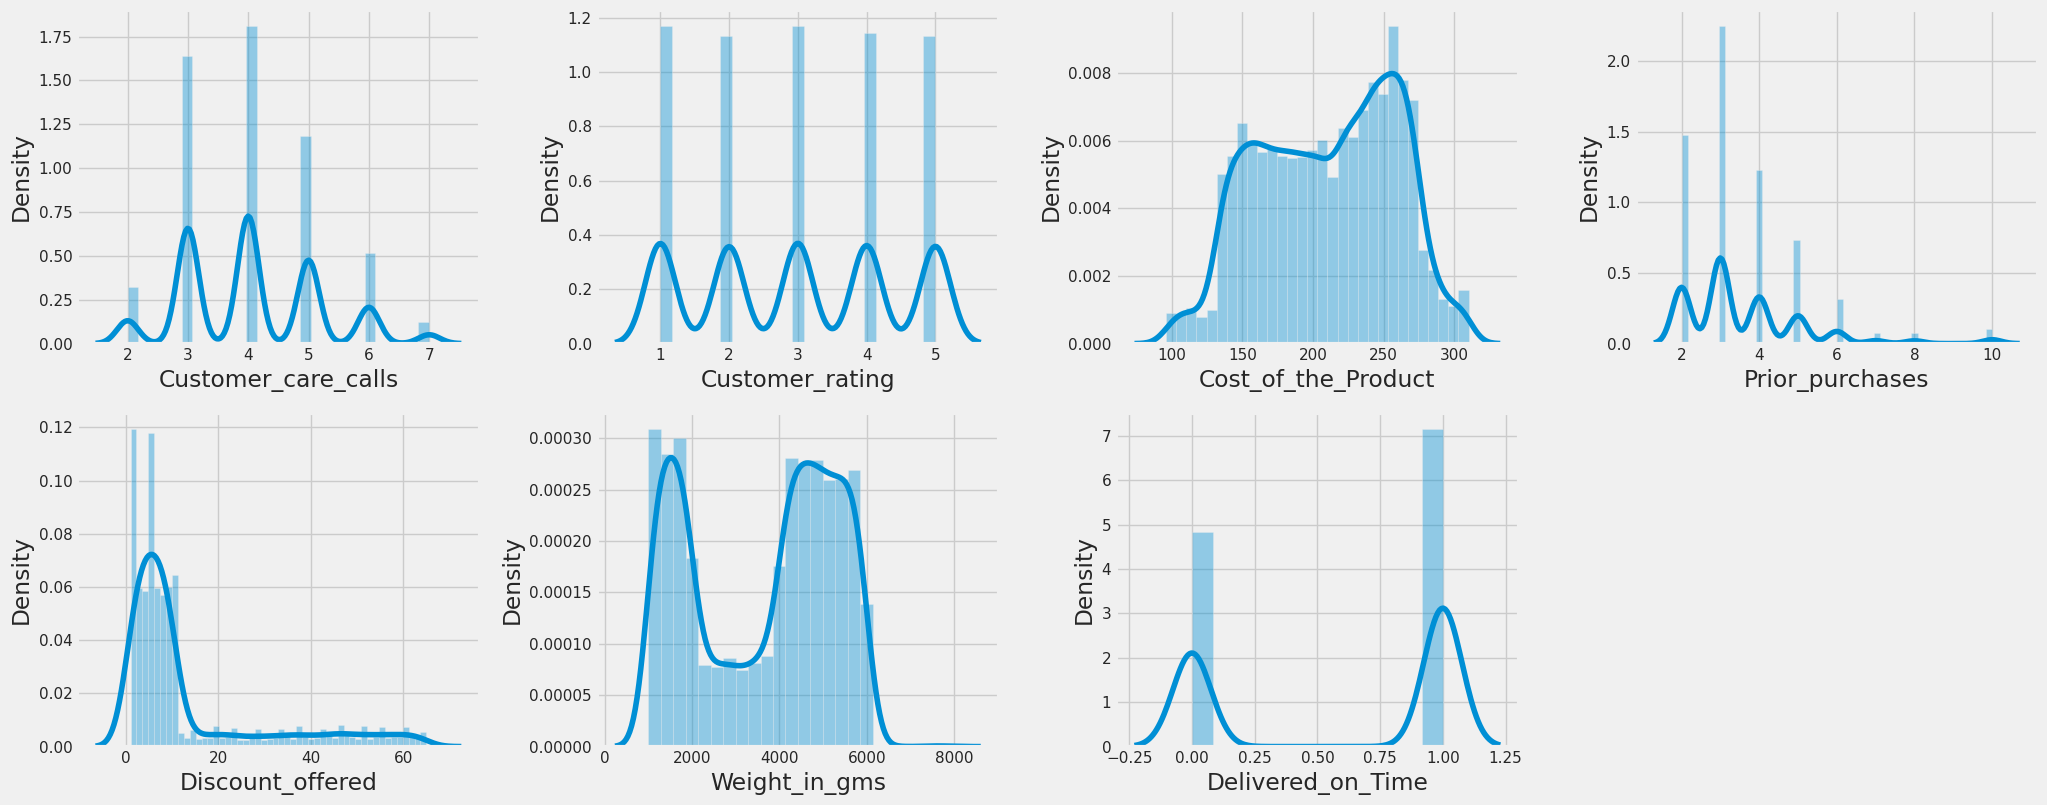

In [ ]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.distplot(df[numerical[i]], kde = True)
    plt.tight_layout()

- Customer_care_calls dan Prior_purchases memiliki sebaran yang mirip (cenderung right-skewed).
- Customer_rating memiliki sebaran unik, dimana tiap nilai rating memiliki nilai yang hampir sama.
- Cost_of_the_Product hampir mendekati sebaran distribusi normal (cenderung left-skewed).
- Discount_offered memiliki sebaran right-skewed.
- Weight_in_gms memiliki sebaran bimodal, dengan distribusi data terpusat pada 2 bagian.
- Delivered_on_Time dengan nilai 1 (pengiriman barang tidak tepat waktu) lebih mendominasi jumlahnya dibandingkan dengan nilai 0 (pengiriman barang tepat waktu).

#### Sebaran Fitur Numerical terhadap Target

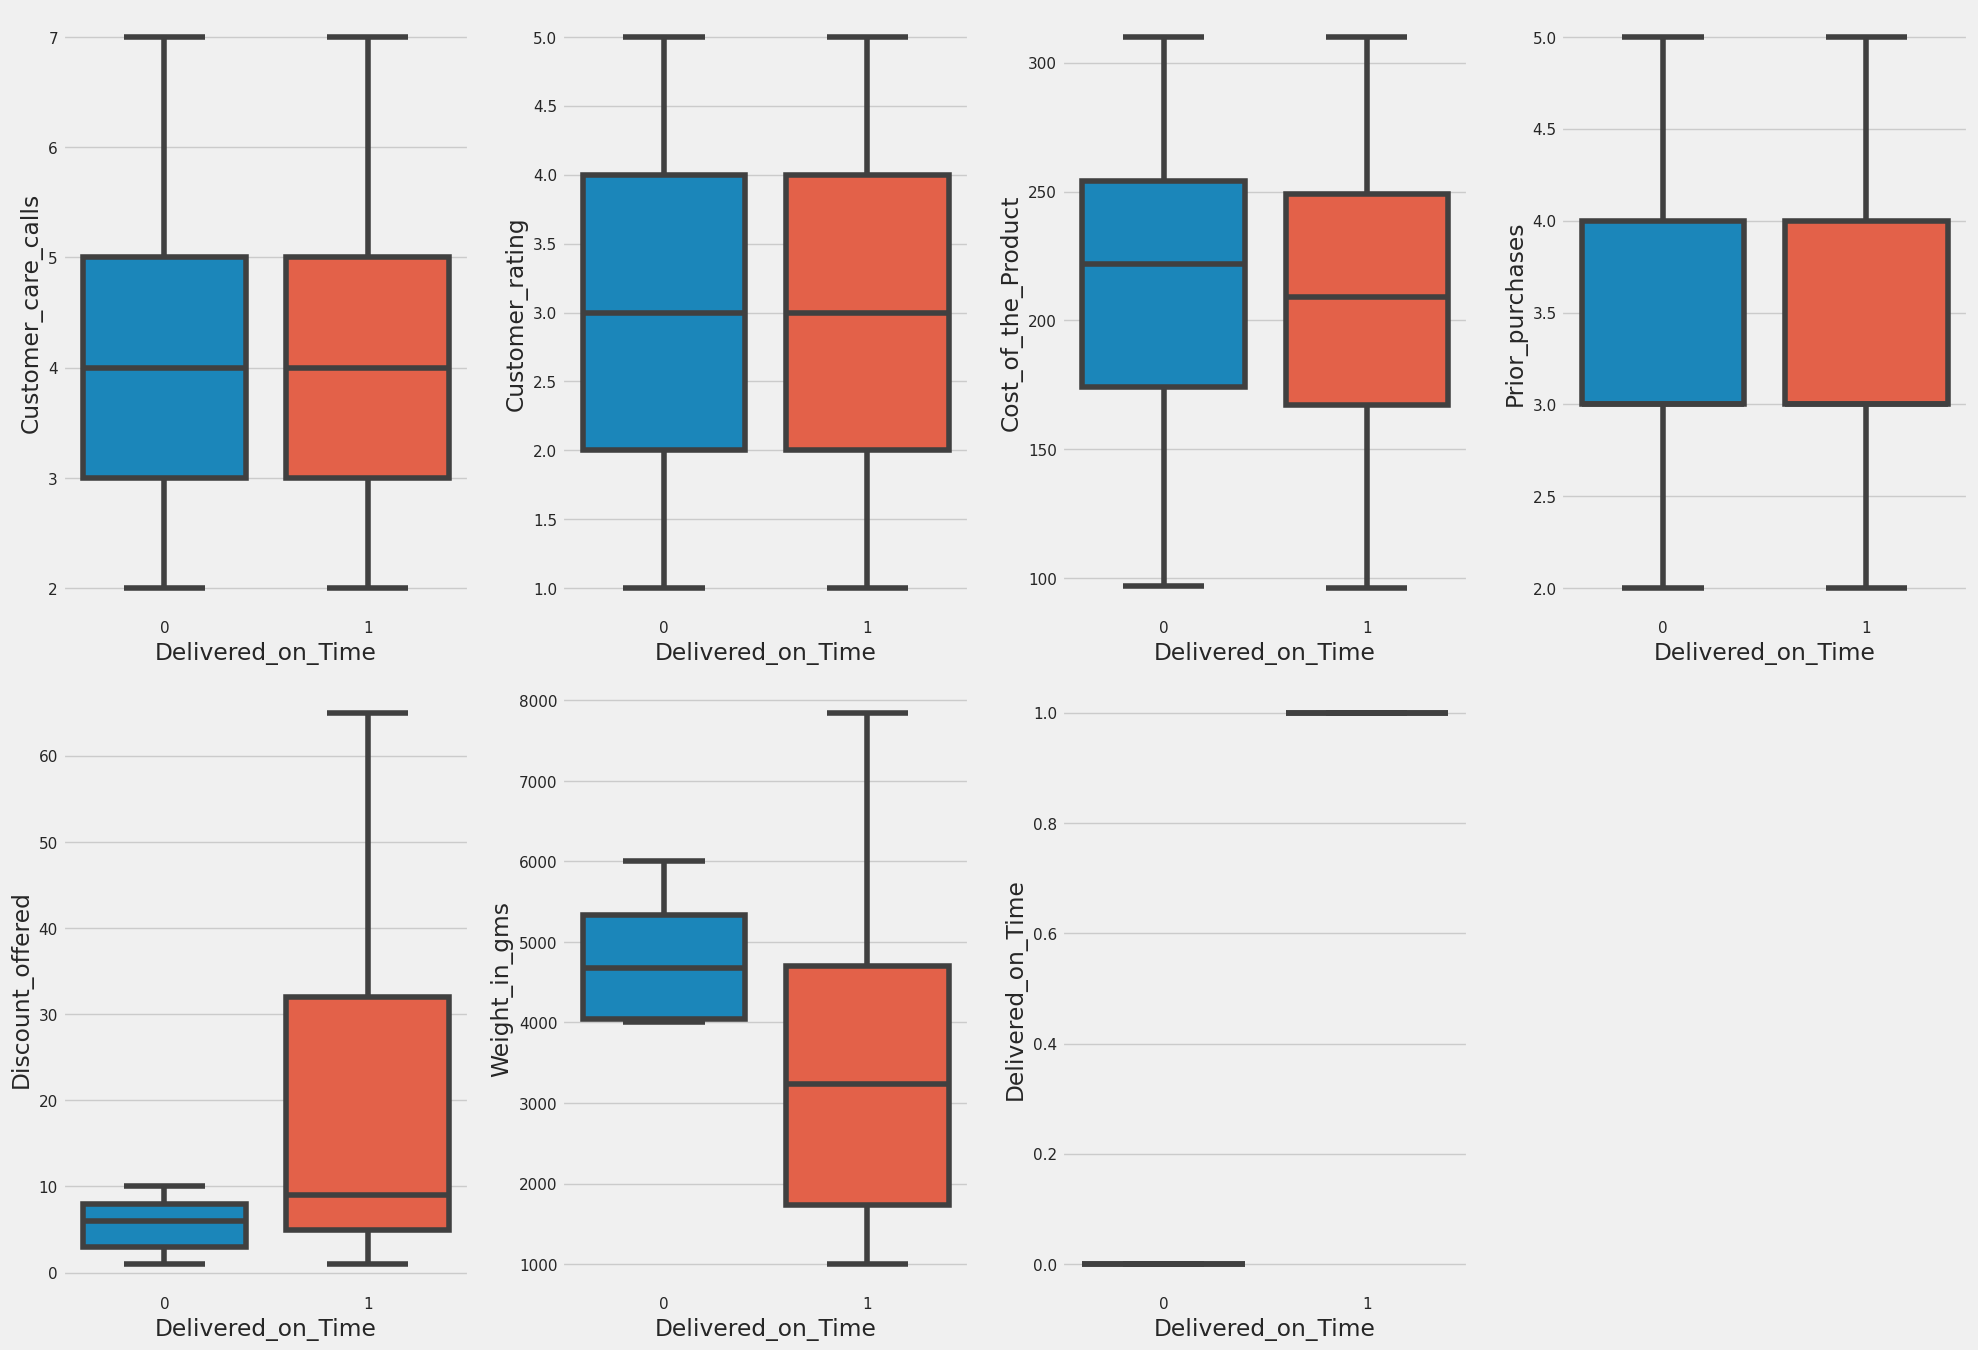

In [ ]:
#Boxplot Features pada Delivered_on_Time
plt.figure(figsize = (20,20))
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=df[numerical[i]], x= 'Delivered_on_Time', data = df, showfliers = False)
    plt.tight_layout()

- Feature Cost_of_the_Product, Discount_offered, dan Weight_in_gms memiliki sebaran cukup berbeda terhadap target Delivered_on_Time, sehingga akan dianalisis lebih lanjut pada ketiga feature terkait.
- Feature Customer_care_calls, Customer_rating, dan Prior_purchases sebarannya hampir sama terhadap target Delivered_on_Time, sehingga EDA tidak berfokus pada ketiga feature ini.

#### Sebaran Fitur Numerical terhadap Target (secara proporsional)

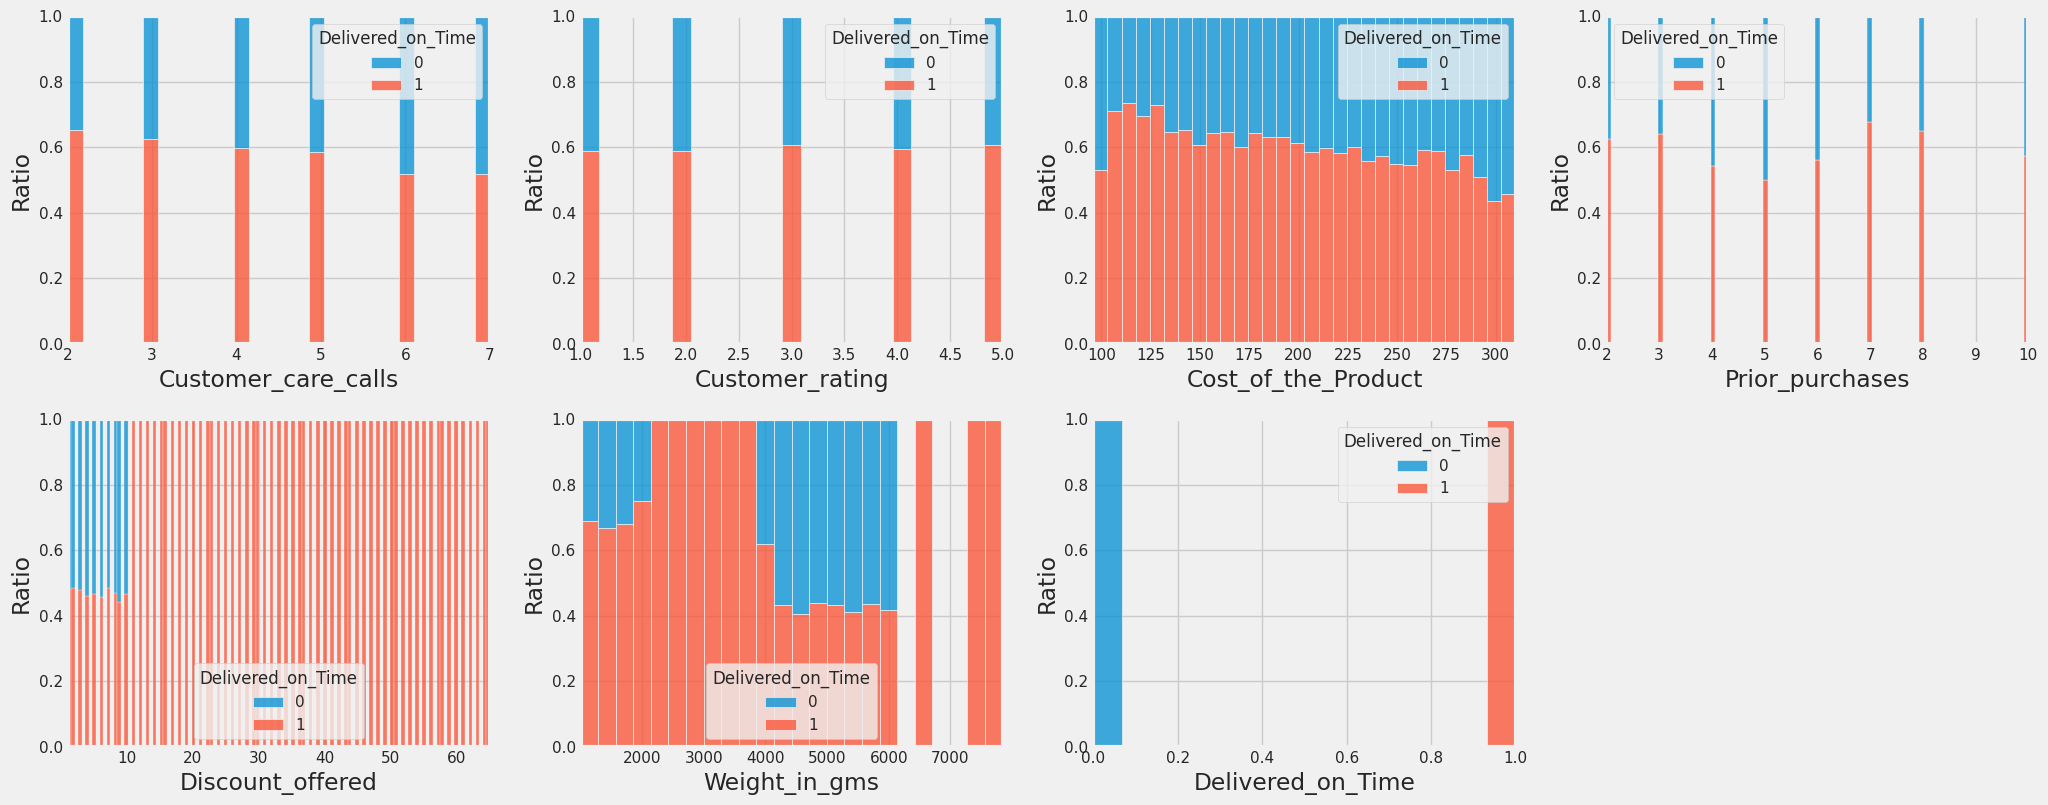

In [ ]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.histplot(x=df[numerical[i]], hue= 'Delivered_on_Time', data = df, multiple = 'fill')
    plt.ylabel('Ratio')
    plt.tight_layout()

- Semua pengiriman barang dengan diskon >10% tidak tepat waktu.
- Pengiriman barang dengan berat di antara 2000 - 4000 g dan di atas 6000 g tidak tepat waktu.
- Harga barang (Cost_of_the_Product) yang semakin tinggi cenderung membuat pengiriman barang tepat waktu.

### Sebaran Feature Categorical

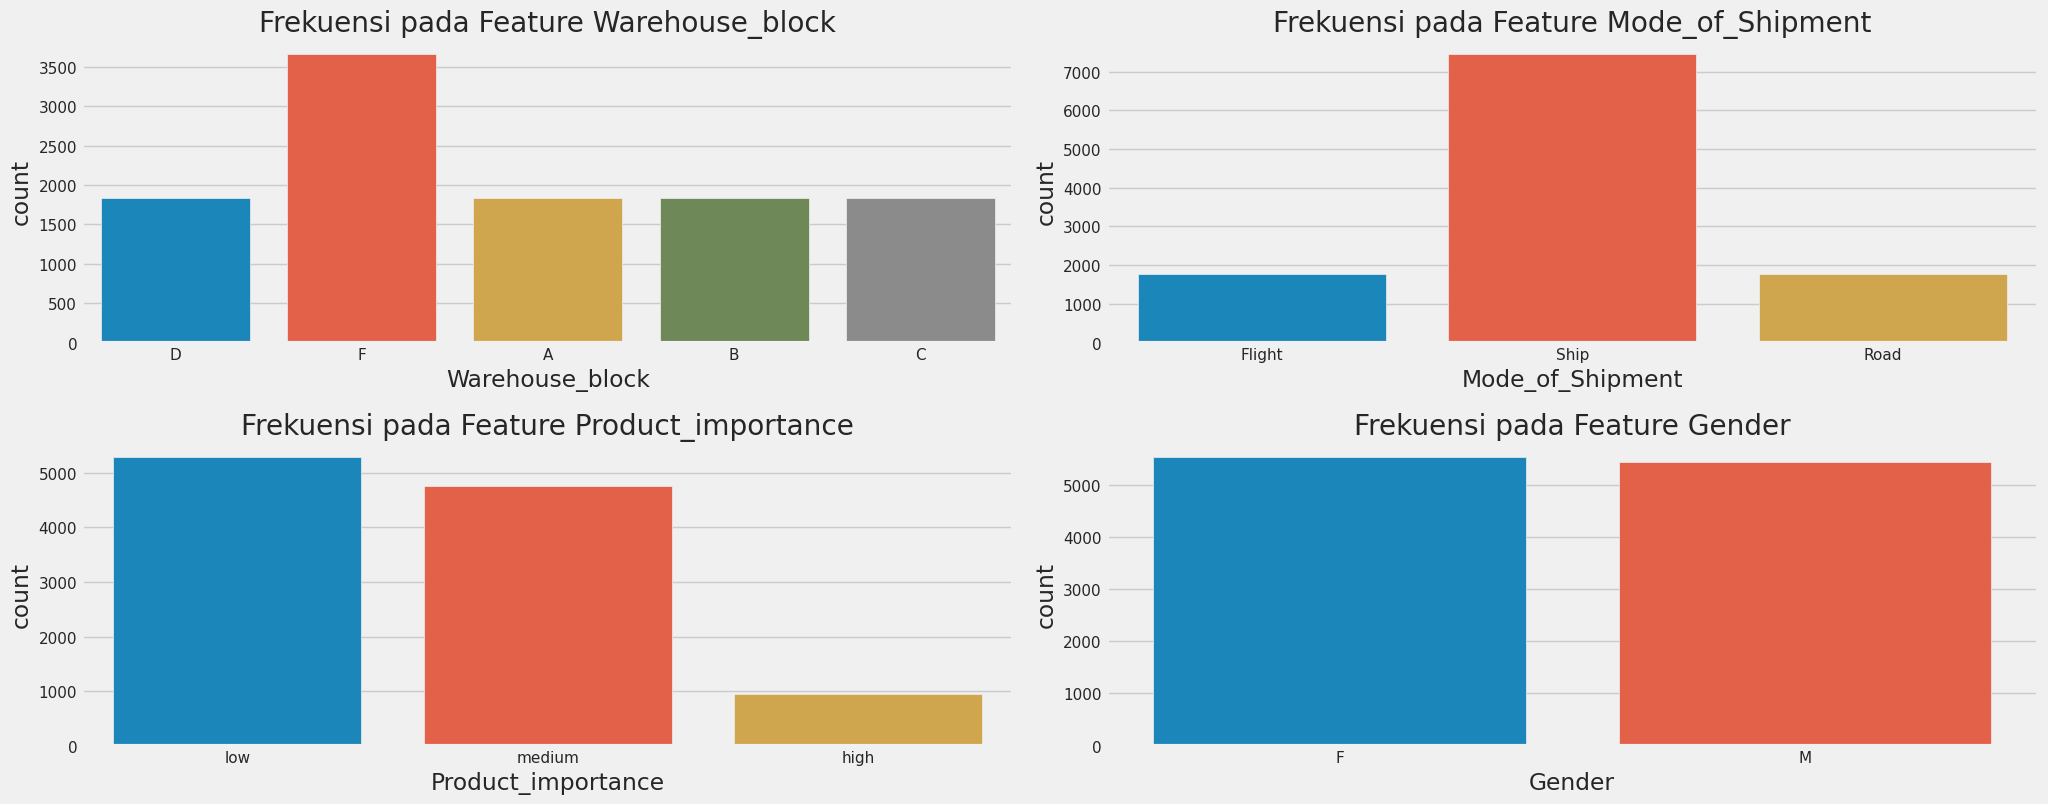

In [ ]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[categorical[i]])
    plt.title(f'Frekuensi pada Feature {categorical[i]}')
    plt.tight_layout()


- Terdapat nilai feature yang mendominasi pada feature Warehouse_block (F), Mode_of_Shipment (Ship).
- Terdapat nilai feature yang menjadi minoritas dalam feature Product_importance (high).
- Nilai feature Gender merata dengan proporsi sekitar 50:50.
- Perbandingan nilai dalam feature tidak terlalu timpang, sehingga keempat fitur masih akan digunakan dalam Exploratory Data Analysis.

### Sebaran Feature Categorical dengan Target (secara proporsional)

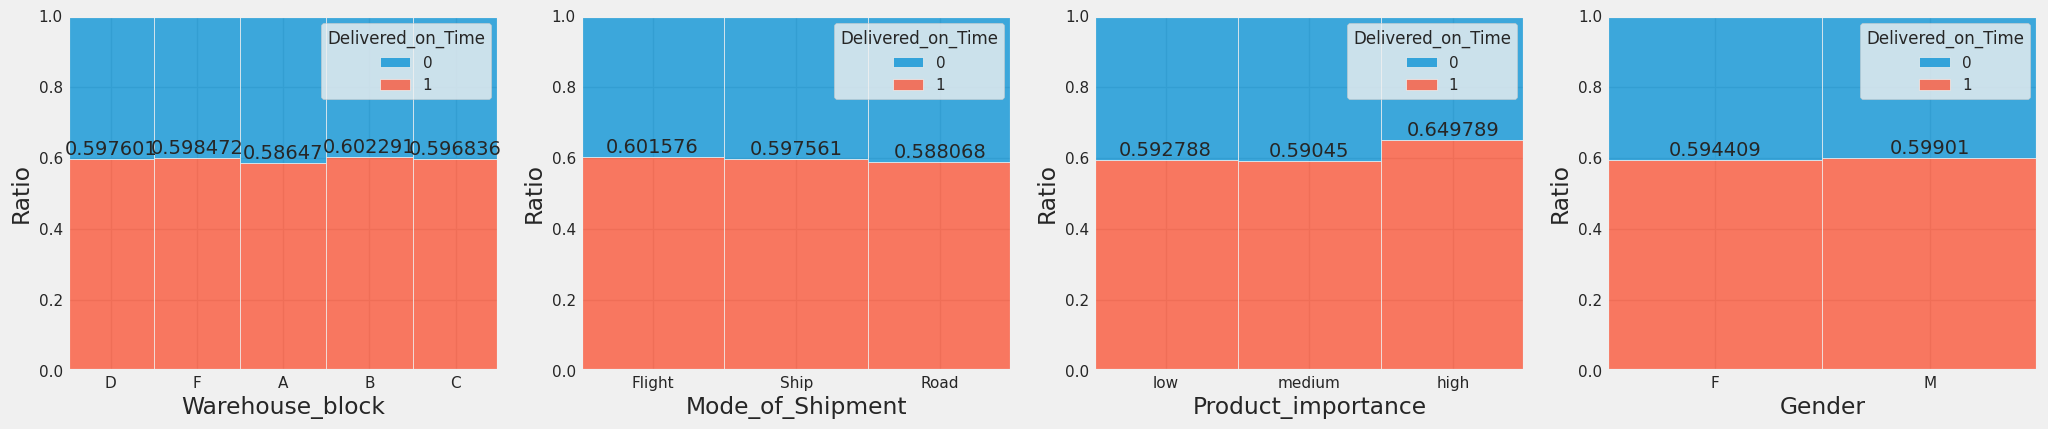

In [ ]:
for i in range(0, len(categorical)):
    fig = plt.subplot(2, 4, i+1)
    sns.histplot(x=df[categorical[i]], hue= 'Delivered_on_Time', data = df, multiple = 'fill')
    plt.bar_label(fig.containers[0])
    plt.ylabel('Ratio')
    plt.tight_layout()

*   Barang yang terkirim tepat waktu terbanyak terdapat di warehouse block A. Sedangkan pada block B, paling banyak barang yang tidak terkirim tepat waktu.
*   Road menjadi metode pengiriman yang paling banyak yang berhasil mengirimkan barang tepat waktu, sedangkan Flight merupakan metode paling banyak yang tidak berhasil mengirim barang tepat waktu.
*   Product_importance yang tergolong low memiliki jumlah barang paling banyak yang berhasil terkirim tepat waktu, sedangkan produk yang tergolong high, paling banyak gagal dalam mengirimkan barang tepat waktu.
*   Rasio barang yang terkirim tepat waktu dengan yang tidak tepat waktu pada feature Gender cenderung sama.



### Follow up untuk Data Pre-Processing

- Akan dilakukan transformasi log untuk variable bersifat right skewed (Prior_purchases dan Discount_offered). Transformasi log dilakukan untuk meminimalisir penghilangan data yang dikategorikan sebagai outlier.
- Feature Weight_in_gms dan Cost_of_the_Product bersifat left skewed, sehingga akan dilakukan juga transformasi data dengan menggunakan standard scaling.
- Melakukan pengelompokkan (grouping) pada feature Weight_in_gms/ Discount_offered/ Cost_of_the_Product.
- Customer_care_calls dan Customer_rating tidak dilakukan transformasi karena sudah mendekati sebaran distribusi normal.
- Akan dilakukan feature encoding pada feature categorical, untuk mengubah nilai feature menjadi numerical.
- Semua feature akan dilakukan scaling sehingga skala antar feature sama.
- Tidak perlu dilakukan handling class imbalance, karena jumlah nilai pada target tidak mengalami ketimpangan (60:40).


# Multivariate Analysis

### Correlation Heatmap

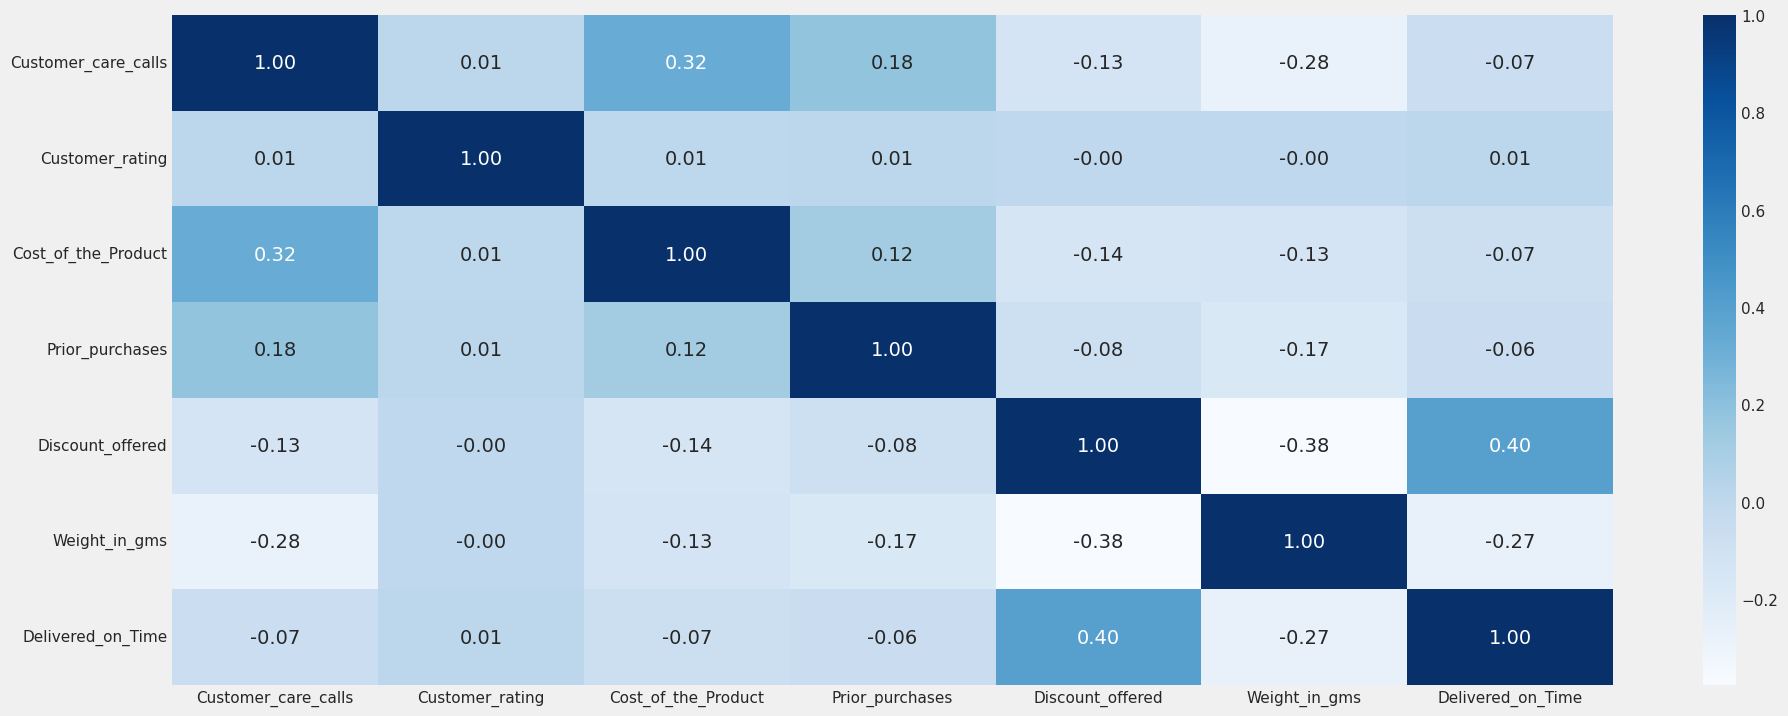

In [ ]:
#kolom id dihilangkan dari analisis univariate dan multivariate
df_copy = df.copy() #df_copy sebagai dataframe baru (tanpa kolom id) untuk analisis heatmap
del df_copy['ID'] #menghapus kolom id pada df_corr untuk analisis heatmap
sns.heatmap(df_copy.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

- Feature Discount_offered berkorelasi positif lemah terhadap target (0.40), sehingga semakin tinggi diskon, semakin tinggi pula kecenderungan untuk barang tidak sampai tepat waktu.
- Feature Weight_in_gms (berat barang) berkorelasi negatif lemah terhadap target (-0.27), sehingga semakin berat barang, semakin tinggi kecenderungan barang untuk terkirim tepat waktu.
- Terdapat korelasi positif lemah antara Customer_care_calls dengan Cost_of_the_Product (0.32). Semakin tinggi harga barang, semakin tinggi pula jumlah customer care calls yang diterima.
- Terdapat korelasi negatif lemah antara Weight_in_gms dengan Discount_offered (-0.38). Semakin tinggi berat barang, semakin kecil nilai diskon yang diberikan.
- Feature lainnya tidak memiliki korelasi secara linier baik dengan antar fitur dan dengan target.

### Korelasi Antar Feature dengan Target

### Pair Plot

<Figure size 500x500 with 0 Axes>

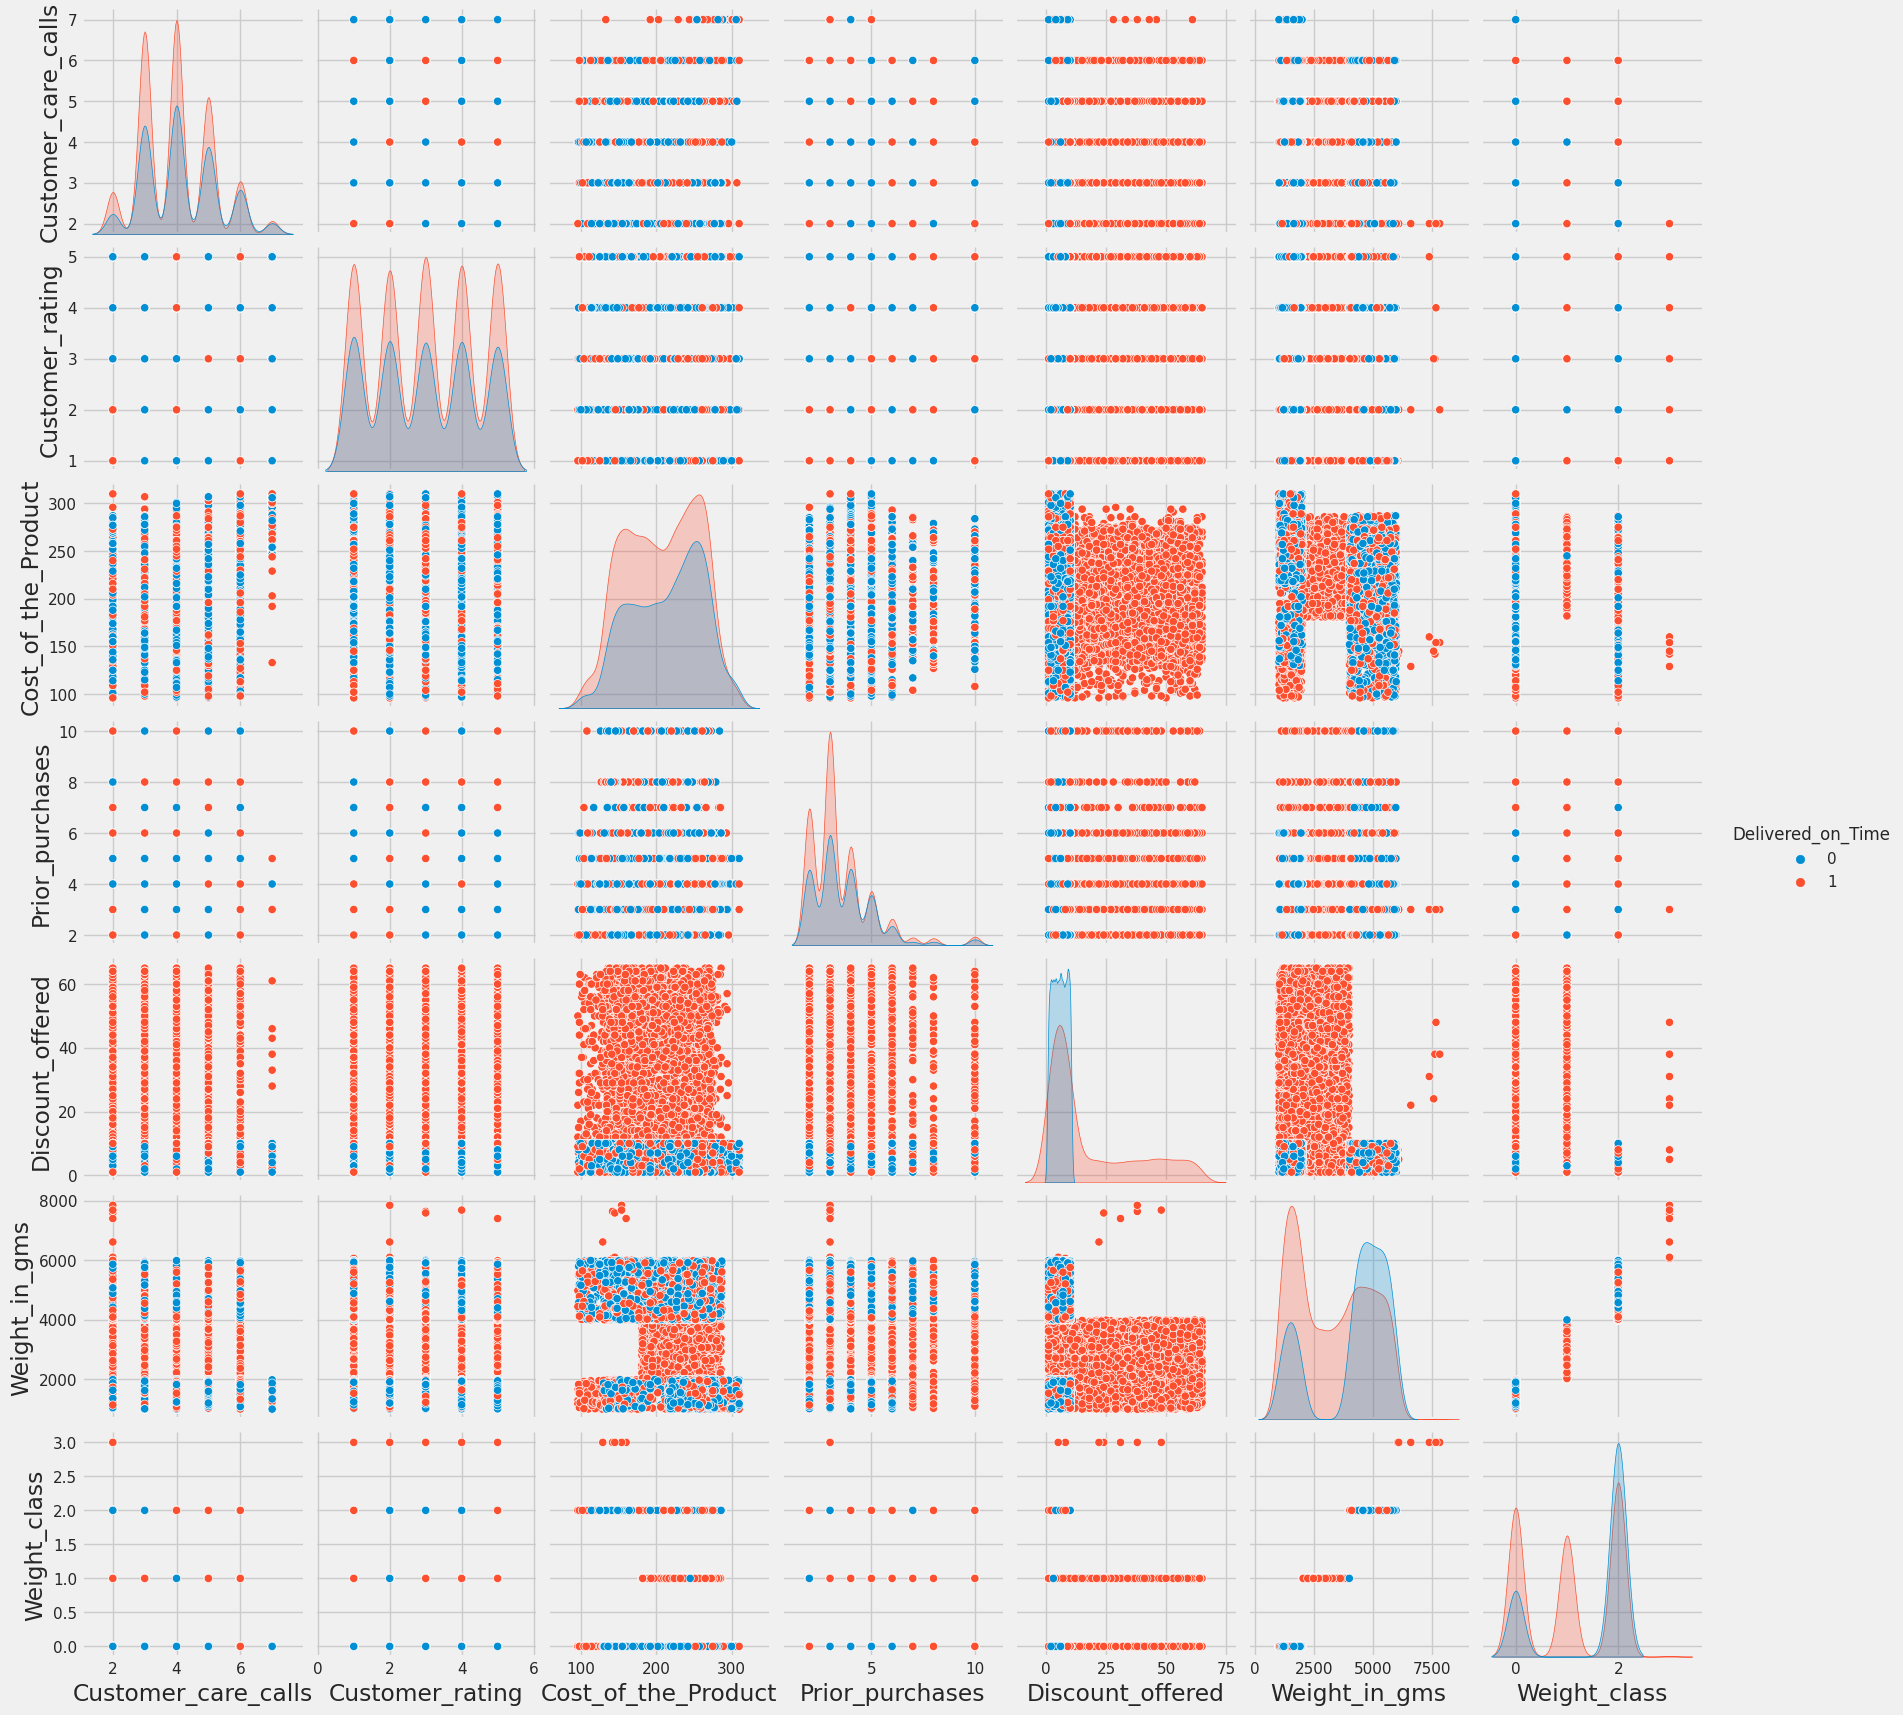

In [ ]:
plt.figure(figsize=(5, 5))
sns.pairplot(df_copy, diag_kind='kde', hue = 'Delivered_on_Time')

- Dari pairplot, didapatkan beberapa hubungan yang menarik (yang cukup terpisah pada variable targetnya) yaitu pada Discount_offered, Cost_of_the_Product, dan Weight_in_gms. Ketiga fitur ini memiliki nilai yang cukup terpisah dengan target, sehingga sangat relevan untuk dipertahankan sebagai fitur pada saat modelling. Ketiga fitur ini akan dianalisis lebih lanjut korelasinya dengan feature kategorikal.
- **Semua barang di antara 2000 hingga 4000 gram dan harga barang yang berada di antara 175 hingga 300 tidak terkirim tepat waktu.**
- **Barang dengan berat di bawah 2000 gram dan harga barang sekitar 100 - 125, tidak terkirim tepat waktu.**
- **Semua barang yang mendapatkan diskon >10% tidak terkirim tepat waktu, berapapun berat dan harga barangnya.**
- Semua barang dengan berat di atas 6000 gram tidak terkirim tepat waktu.

### Sebaran Feature Numerical (Discount_offered) dengan Feature Categorical (Warehouse_block, Mode_of_Shipment, Product_importance, dan Gender) pada Target

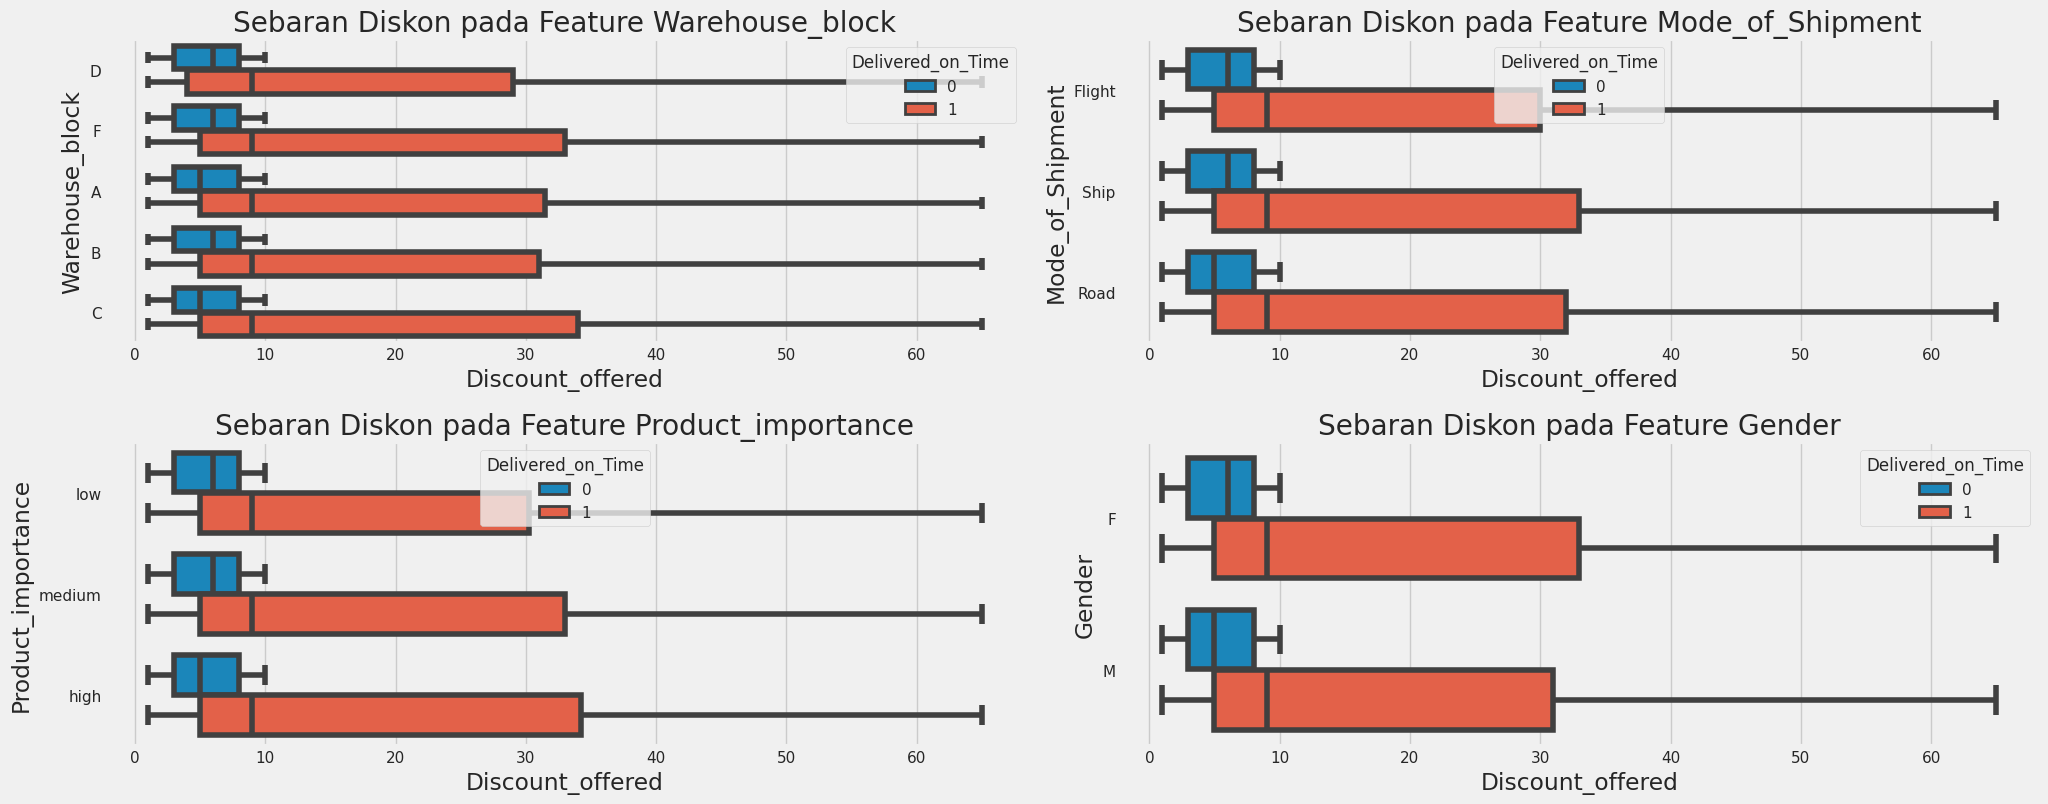

In [ ]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[categorical[i]], x='Discount_offered', showfliers = False, data=df, hue='Delivered_on_Time')
    plt.title(f'Sebaran Diskon pada Feature {categorical[i]}')
    plt.tight_layout()

*   Warehouse block A memberikan diskon yang cenderung lebih sedikit dibandingkan dengan Warehouse block lainnya, mengkonfirmasi pengamatan sebelumnya dimana Warehouse block A lebih tepat waktu dalam pengiriman barang.
*   Mode_of_Shipment tipe Road memberikan diskon yang lebih kecil dibandingkan dengan tipe Flight dan Ship, dimana hal ini mengkonfirmasi mode Road menjadi metode yang paling banyak mengirimkan barang tepat waktu.
*   Sebagian barang dengan diskon < 10% tidak mengalami keterlambatan pengiriman pada feature Warehouse_block, Product_importance, Mode_of_Shipment, maupun Gender.
*   Sementara barang dengan diskon > 10% semuanya mengalami keterlambatan.








# Insight

1. Diskon Tinggi Berkorelasi Positif dengan Pengiriman Tidak Tepat Waktu.
2. Berat Barang dan Harga Barang berpengaruh pada Pengiriman Tepat Waktu.
3. Warehouse Block dan Mode of Shipment Memengaruhi Diskon dan Pengiriman Tepat Waktu.

# Data Pre-Processing

# Handling Missing Value

In [ ]:
df.isna().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Delivered_on_Time      False
dtype: bool

Tidak ditemukan missing value pada dataset.

# Handling Duplicate Data

In [ ]:
df.duplicated().any()

False

Tidak terdapat duplicate data pada dataset.

# Handling Invalid Values

In [ ]:
df.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Delivered_on_Time
count,10999,10999,10999,10999.000000,10999.000000,10999.000000,10999.000000,10999,10999,10999.000000,10999.000000,10999.000000
unique,10999,5,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,1,F,Ship,NaN,NaN,NaN,NaN,low,F,NaN,NaN,NaN
freq,1,3666,7462,NaN,NaN,NaN,NaN,5297,5545,NaN,NaN,NaN
mean,NaN,NaN,NaN,4.054459,2.990545,210.196836,3.567597,NaN,NaN,13.373216,3634.016729,0.596691
std,NaN,NaN,NaN,1.141490,1.413603,48.063272,1.522860,NaN,NaN,16.205527,1635.377251,0.490584
min,NaN,NaN,NaN,2.000000,1.000000,96.000000,2.000000,NaN,NaN,1.000000,1001.000000,0.000000
25%,NaN,NaN,NaN,3.000000,2.000000,169.000000,3.000000,NaN,NaN,4.000000,1839.500000,0.000000
50%,NaN,NaN,NaN,4.000000,3.000000,214.000000,3.000000,NaN,NaN,7.000000,4149.000000,1.000000
75%,NaN,NaN,NaN,5.000000,4.000000,251.000000,4.000000,NaN,NaN,10.000000,5050.000000,1.000000


Dilihat dari semua features yang ada, tidak terdapat nilai invalid yang ditemukan dari data statistik dan nilai unique value, yang telah dicek pada tahap EDA.

# Feature Extraction

Sebelum melakukan lebih jauh data preprocessing, dilakukan terlebih dahulu feature extraction dan selection, sehingga feature yang dikurangi/ditambahkan dapat ikut diolah pada proses data preprocessing selanjutnya.

Berdasarkan hasil EDA pada feature Weight_in_gms, distribusi berat barang yang ada pada dataset memiliki distribusi bimodal. Karena itu, dilakukan feature extraction dari feature Weight_in_gms untuk mengelompokkan berat barang menjadi 4 kategori:
1. Berat barang <= 2000 g
2. Berat barang pada 2001 - 4000 g
3. Berat barang pada 4001 - 6000 g
2. Berat barang > 6000 g


In [ ]:
def weight_class(category):

    if category <= 2000:
        return 0
    elif category <= 4000:
        return 1
    elif category <= 6000:
        return 2
    else:
        return 3

In [ ]:
#klasifikasi berat barang
df['Weight_class'] = df['Weight_in_gms'].apply(lambda x: weight_class(x))
df.sample(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Delivered_on_Time,Weight_class
1352,1353,A,Road,4,1,162,2,low,F,47,1540,1,0
7726,7727,C,Ship,7,3,308,4,medium,M,6,1113,0,0
5131,5132,F,Ship,5,1,265,3,high,M,5,4951,1,2
6662,6663,A,Ship,4,1,200,4,medium,M,3,5837,0,2
4229,4230,F,Road,5,4,172,4,medium,F,10,4659,1,2
61,62,F,Ship,3,3,179,3,medium,M,52,1158,1,0
698,699,A,Flight,4,3,264,3,medium,M,23,2376,1,1
9273,9274,B,Ship,3,3,150,3,medium,M,9,5852,0,2
2487,2488,B,Ship,5,2,132,2,medium,M,8,1665,1,0
7241,7242,F,Road,4,5,129,5,medium,M,7,5554,1,2


# Feature Selection

Feature selection dilakukan berdasarkan 3 metode:
1. Melihat korelasi antar feature yang kuat (multicolinearity)
2. Melihat feature yang memiliki low variance (data numerik) dan low entropy (data kategorikal).
3. Menghitung nilai Weight of Evidence (WoE) dan Information Value (IV) pada masing-masing feature untuk mengetahui kekuatan pengaruh tiap feature dalam memprediksi nilai target.

## Feature Selection Metode 1

Feature Selection Metode 1 dilakukan dengan melihat korelasi antar fitur dan fitur dengan target.

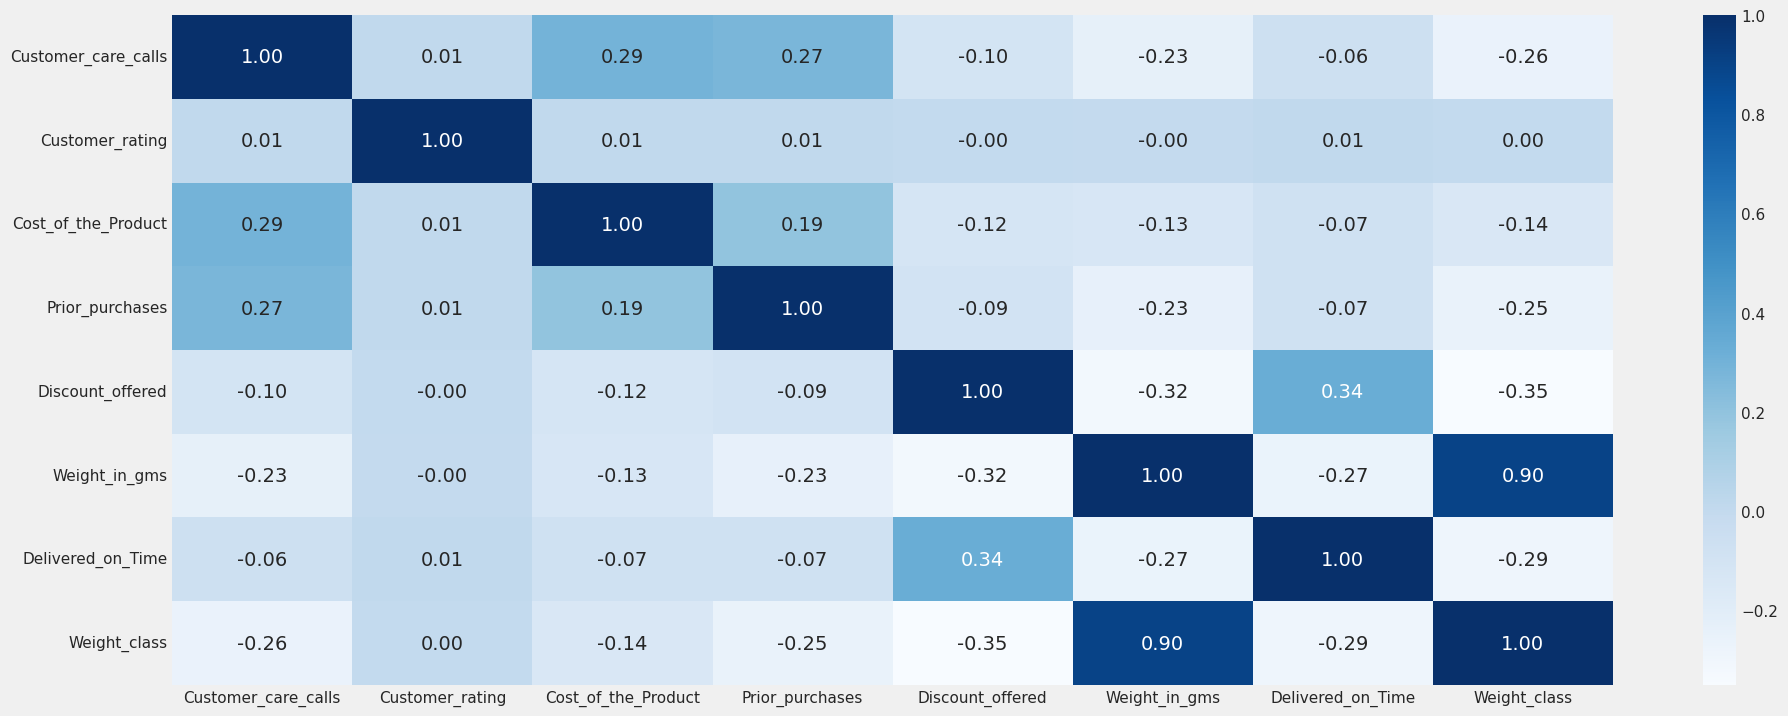

In [ ]:
df_copy = df.copy() #df_copy sebagai dataframe baru (tanpa kolom id) untuk analisis heatmap
del df_copy['ID'] #menghapus kolom id pada df_corr untuk analisis heatmap
sns.heatmap(df_copy.corr(method = 'spearman'), cmap='Blues', annot=True, fmt='.2f')
plt.show()

- Feature Weight_in_gms dan Weight_class memiliki berkorelasi secara kuat (0.95), sehingga diputuskan untuk menghilangkan feature Weight_in_gms.
- Nilai korelasi Weight_class dengan Delivered_on_Time lebih tinggi (-0.29) dibandingkan dengan nilai korelasi Weight_in_gms dengan Delivered_on_Time (-0.27).
- Penghilangan fitur Weight_in_gms dilakukan untuk menghilangkan efek multicolinearity.  

In [ ]:
df = df.drop('Weight_in_gms', axis = 1)

## Feature Selection Metode 2

Feature Selection Metode 2 dilakukan dengan melihat sebaran nilai pada dataset untuk mengetahui apakah ada feature yang memiliki low variance atau low entropy.

In [ ]:
numerical = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_class']

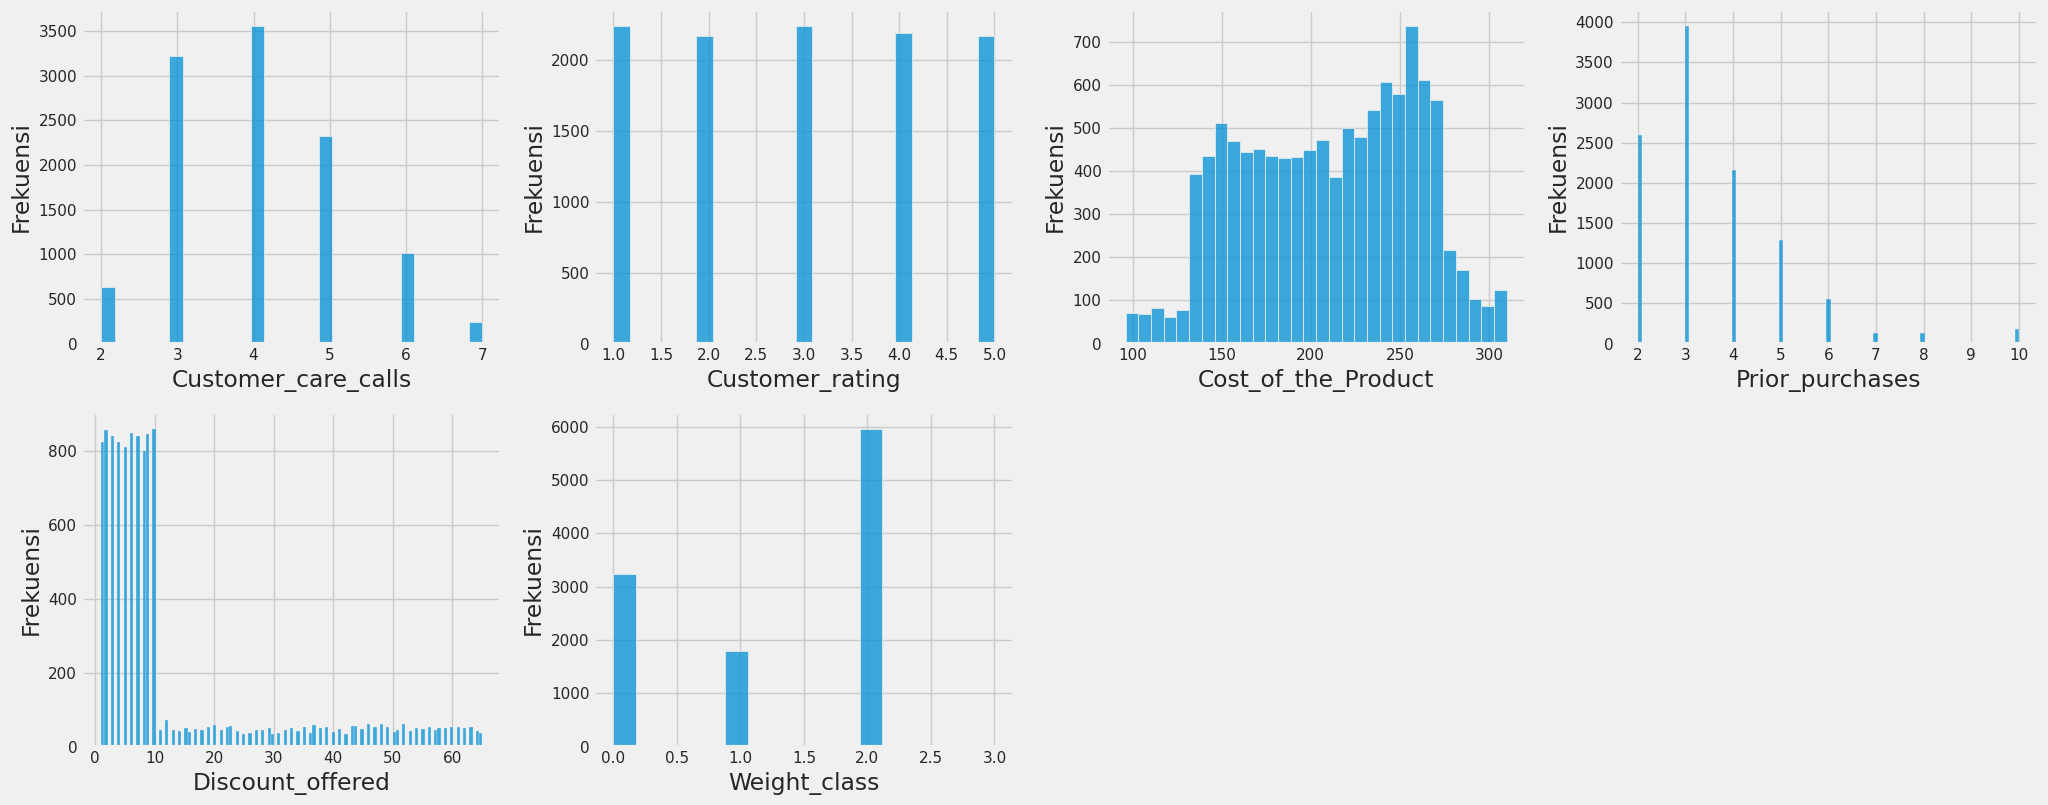

In [ ]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.histplot(x=df[numerical[i]], data = df)
    plt.ylabel('Frekuensi')
    plt.tight_layout()

- Keenam feature numerik tidak memiliki low variance, sehingga feature selection belum dapat dilakukan dengan Metode 2.

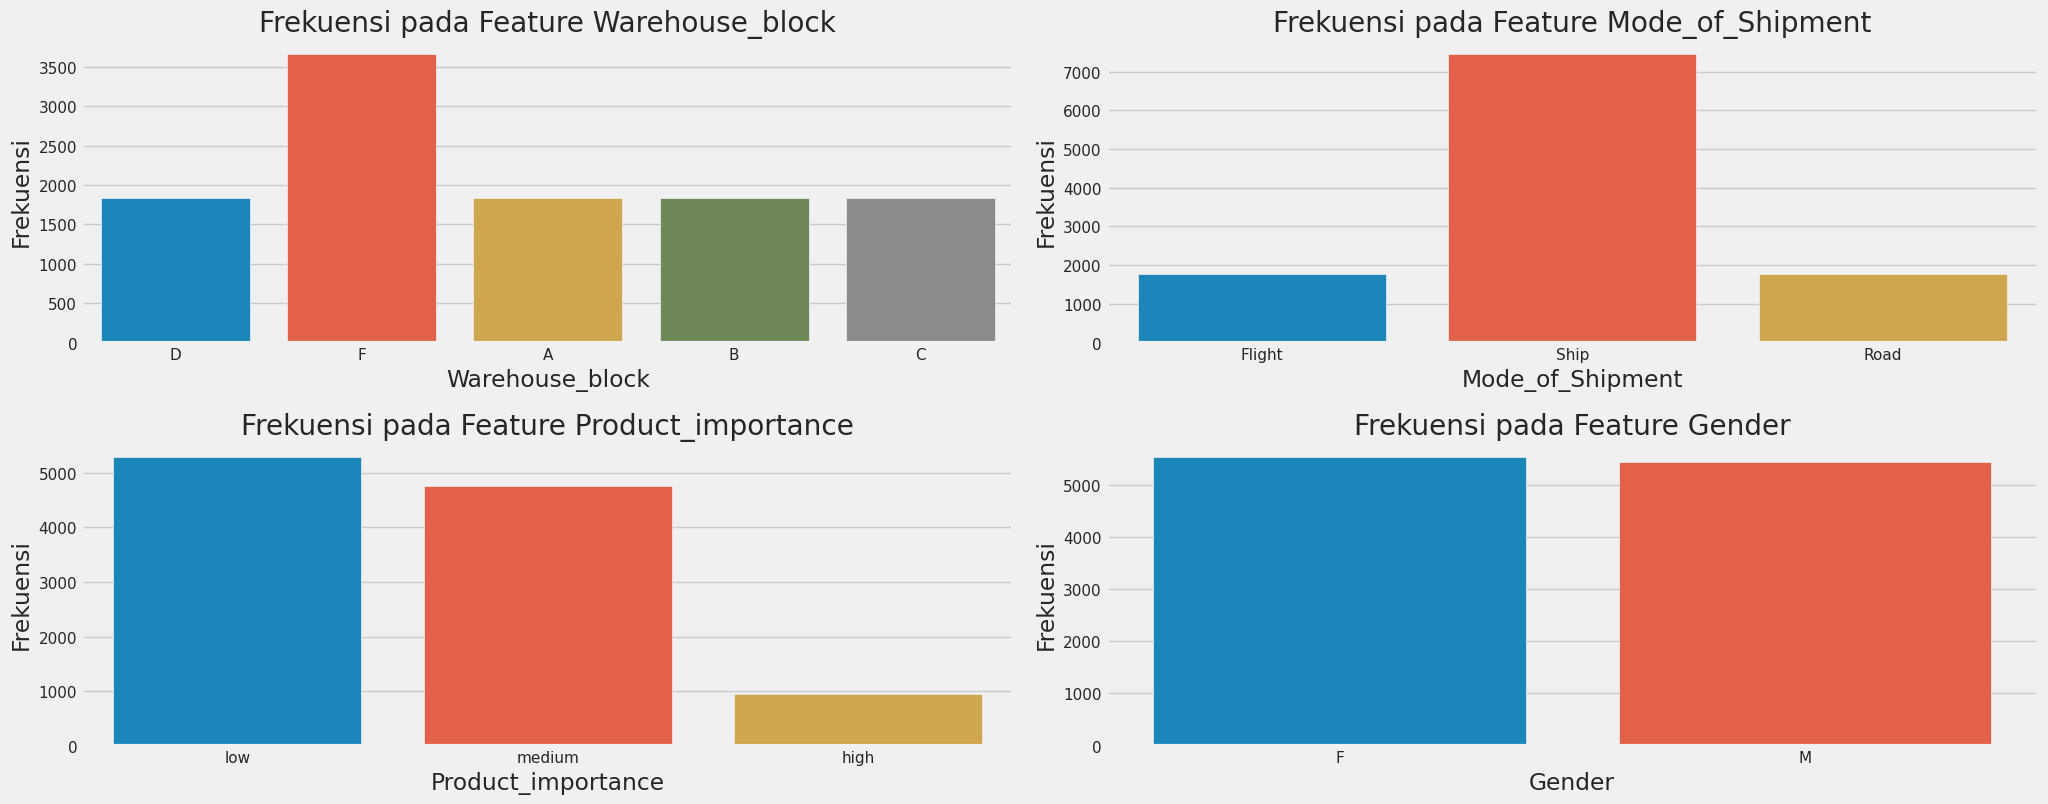

In [ ]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[categorical[i]])
    plt.title(f'Frekuensi pada Feature {categorical[i]}')
    plt.ylabel('Frekuensi')
    plt.tight_layout()

- Dari keempat feature kategorikal yang ada, tidak ada feature yang berpusat pada 1 kategori memiliki low entropy, sehingga feature selection belum dapat dilakukan pada feature kategorikal dengan Metode 2.

## Feature Selection Metode 3

*   Feature selection Metode 3 dilakukan dengan analisis nilai Weight of Evidence (WoE) dan Infomation Value (IV). Tabel yang menunjukkan nilai prediksi berdasarkan Information Value ditunjukkan pada gambar berikut.

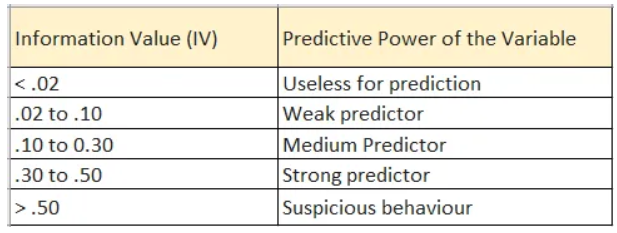









In [ ]:
list_column_raw = list(df.columns)
drop_column_bin = ['ID', 'Delivered_on_Time']

list_column = [i for i in list_column_raw if i not in drop_column_bin]

x_bin = df[list_column]
y_bin = df.Delivered_on_Time

In [ ]:
#Start Binning for WoE
binning_fit_params = dict.fromkeys(list_column, {'monotonic_trend': 'auto_asc_desc',\
                                                  'min_n_bins':2, 'max_n_bins':10})
binning_process    = BinningProcess(list_column, binning_fit_params=binning_fit_params)
binning_process.fit(x_bin, y_bin)

appended_data = []
for i in list_column:
    optb = binning_process.get_binned_variable(i)

    # store DataFrame in list
    data = optb.binning_table.build()
    data['features'] = i
    appended_data.append(data)
appended_data = pd.concat(appended_data)

features = binning_process.summary()[binning_process.summary()['selected'] == True]['name'].tolist()
woe = appended_data.copy()

woe['% of Event']     = np.maximum(woe['Event'], 0.5) / y_bin[y_bin == 1].shape[0]
woe['% of Non-event'] = np.maximum(woe['Non-event'], 0.5) / y_bin[y_bin == 0].shape[0]

# Transform Binning Value to WoE

data_transform = binning_process.transform(x_bin, metric='woe')
data_transform['Delivered_on_Time'] = df['Delivered_on_Time']

# Nilai IV merupakan nilai sum dari IV setiap bin
summary_woe_iv = binning_process.summary()
summary_woe_iv.sort_values('iv', ascending = False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
8,Discount_offered,numerical,OPTIMAL,True,2,0.727921,0.085013,0.36095,0.323539
9,Weight_class,numerical,OPTIMAL,True,2,0.598112,0.072643,0.371321,0.526345
5,Prior_purchases,numerical,OPTIMAL,True,3,0.036455,0.004549,0.094644,0.027663
4,Cost_of_the_Product,numerical,OPTIMAL,True,7,0.026988,0.003364,0.090206,0.00559
2,Customer_care_calls,numerical,OPTIMAL,True,5,0.020348,0.002535,0.072987,0.040471
6,Product_importance,categorical,OPTIMAL,True,3,0.004722,0.000589,0.02104,0.002653
3,Customer_rating,numerical,OPTIMAL,True,4,0.001005,0.000126,0.016938,0.000024
0,Warehouse_block,categorical,OPTIMAL,True,5,0.000411,0.000051,0.009798,0.0
1,Mode_of_Shipment,categorical,OPTIMAL,True,3,0.00028,0.000035,0.007562,0.000093
7,Gender,categorical,OPTIMAL,True,2,0.000091,0.000011,0.004779,0.000096


Berdasarkan nilai pada kolom iv, **nilai diatas 0,5** terdapat pada feature **Discount_offered dan Weight_class**. Kedua feature ini dikategorikan sebagai feature dengan **suspicious behavior** atau diduga berkorelasi sangat tinggi dengan target. Karena jumlah feature pada dataset tidak terlalu banyak, maka diputuskan untuk mempertahankan feature yang masuk dalam kategori ini.
*   Feature **Product_importance, Customer_rating, Warehouse_block,	Mode_of_Shipment, dan Gender** memiliki nilai iv < 0,02, dimana feature yang masuk kategori ini tidak signifikan untuk digunakan pada proses modeling. Feature yang masuk dalam kategori ini akan dihilangkan, kecuali feature **Product_importance**, karena pada proses EDA ditemukan bahwa feature ini memiliki pengaruh terhadap target.
*   Sehingga feature yang akan digunakan adalah:
1. Discount_offered
2. Weight_class
3. Prior_purchases
4. Cost_of_the_Product
5. Customer_care_calls
6. Product_importance

# Feature Encoding

Terdapat 1 feature bertipe kategorikal pada dataset, yaitu Product_importance. Sebelum melanjutkan data preprocessing, dilakukan terlebih dahulu feature encoding.

Akan dilakukan teknik Label Encoding untuk Feature Encoding pada feature Product_importance, karena Product_importance merupakan feature kategorikal yang bertipe ordinal.

In [ ]:
#label encoding untuk product importance
df['Product_importance'] = df['Product_importance'].map({'low' : 0, 'medium': 1, 'high': 2})

# Handling Outlier

Sebelum dilakukan data preprocessing lebih lanjut, dataset akan di split menjadi data train dan data test, untuk menghindari data leakage dari data train ke data test.

In [ ]:
# memisahkan kolom feature dan target
X= df[['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases','Product_importance', 'Discount_offered','Weight_class']]
y= df[['Delivered_on_Time']]

In [ ]:
# pemisahan data train dan data test dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
X_train.shape

(8799, 6)

In [ ]:
X_test.shape

(2200, 6)

In [ ]:
numerical = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_class', 'Product_importance']

###Pengamatan feature numerik (data train) sebelum handling outlier

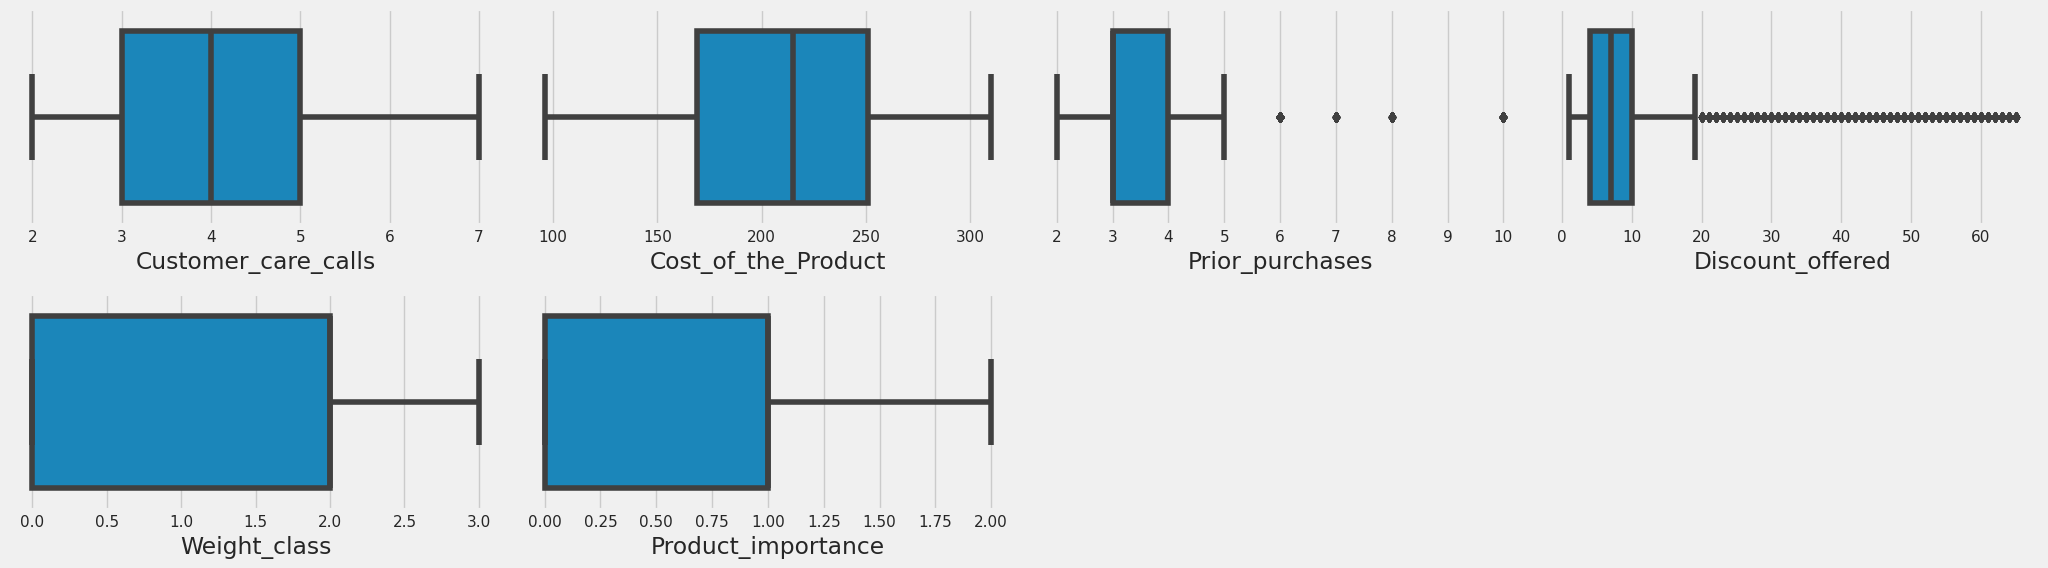

In [ ]:
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=X_train[numerical[i]])
    plt.tight_layout()

Dilihat dari sebaran feature pada dataset, feature Prior_purchases memiliki global outlier pada nilai 10. Dilakukan pengecekan pada jumlah data yang memiliki Prior_purchases = 10.

In [ ]:
X_train[X_train['Prior_purchases']==10]

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_class
2067,2,225,10,2,46,1
8589,3,195,10,0,9,2
9084,2,204,10,0,1,2
6794,4,134,10,1,8,2
4084,3,273,10,1,10,2
...,...,...,...,...,...,...
1150,3,148,10,2,12,0
6799,3,265,10,0,10,2
7385,3,146,10,0,5,2
2558,4,162,10,2,25,0


Dilihat dari jumlah data orang dengan prior purchases sebanyak 151. Jumlah data cukup banyak apabila dihilangkan sebagai outlier, maka diputuskan untuk tidak menghilangkan data dengan Prior_purchases =10.

Sebaran feature lain pada data train tidak ditemukan global outlier (hanya ada collective outlier), maka diputuskan untuk tidak melakukan handling pada outlier yang ditemukan. Dataset nantinya akan langsung ditransformasi dengan metode transformasi yang robust terhadap outlier untuk mendapatkan distribusi normal.  

# Feature Transformation

In [ ]:
X_train1 = X_train.copy() #variabel sementara untuk trial dan error proses transformasi data

In [ ]:
X_test1 = X_test.copy()

Dilakukan transformasi data pada feature Cost_of_the_Product dan Discount_offered dengan metode Quantile Transformation. Feature lain tidak dilakukan transformasi data, karena feature memiliki nilai diskrit.

In [ ]:
# membuat fungsi untuk transformasi
def transformation(data):
  transformed_data = data.copy()
  transformed_data['Discount_offered'] = transform_Discount_offered.transform(data['Discount_offered'].values.reshape(-1, 1))
  transformed_data['Cost_of_the_Product'] = transform_Cost_of_the_Product.transform(data['Cost_of_the_Product'].values.reshape(-1, 1))
  return transformed_data

In [ ]:
# Data Transformation

transform_Discount_offered = QuantileTransformer(output_distribution = 'normal', random_state = 42)
transform_Cost_of_the_Product = QuantileTransformer(output_distribution = 'normal', random_state = 42)

transform_Discount_offered.fit(X_train1['Discount_offered'].values.reshape(-1, 1))
transform_Cost_of_the_Product.fit(X_train1['Cost_of_the_Product'].values.reshape(-1, 1))

X_train_transformation = transformation(X_train1)
X_test_transformation = transformation(X_test1)


### Perbandingan Sebelum dan Sesudah Data Transformation

### Transformasi Data Train

In [ ]:
# list kolom yang dilakukan data transformation
list_transformation = ['Discount_offered', 'Cost_of_the_Product']

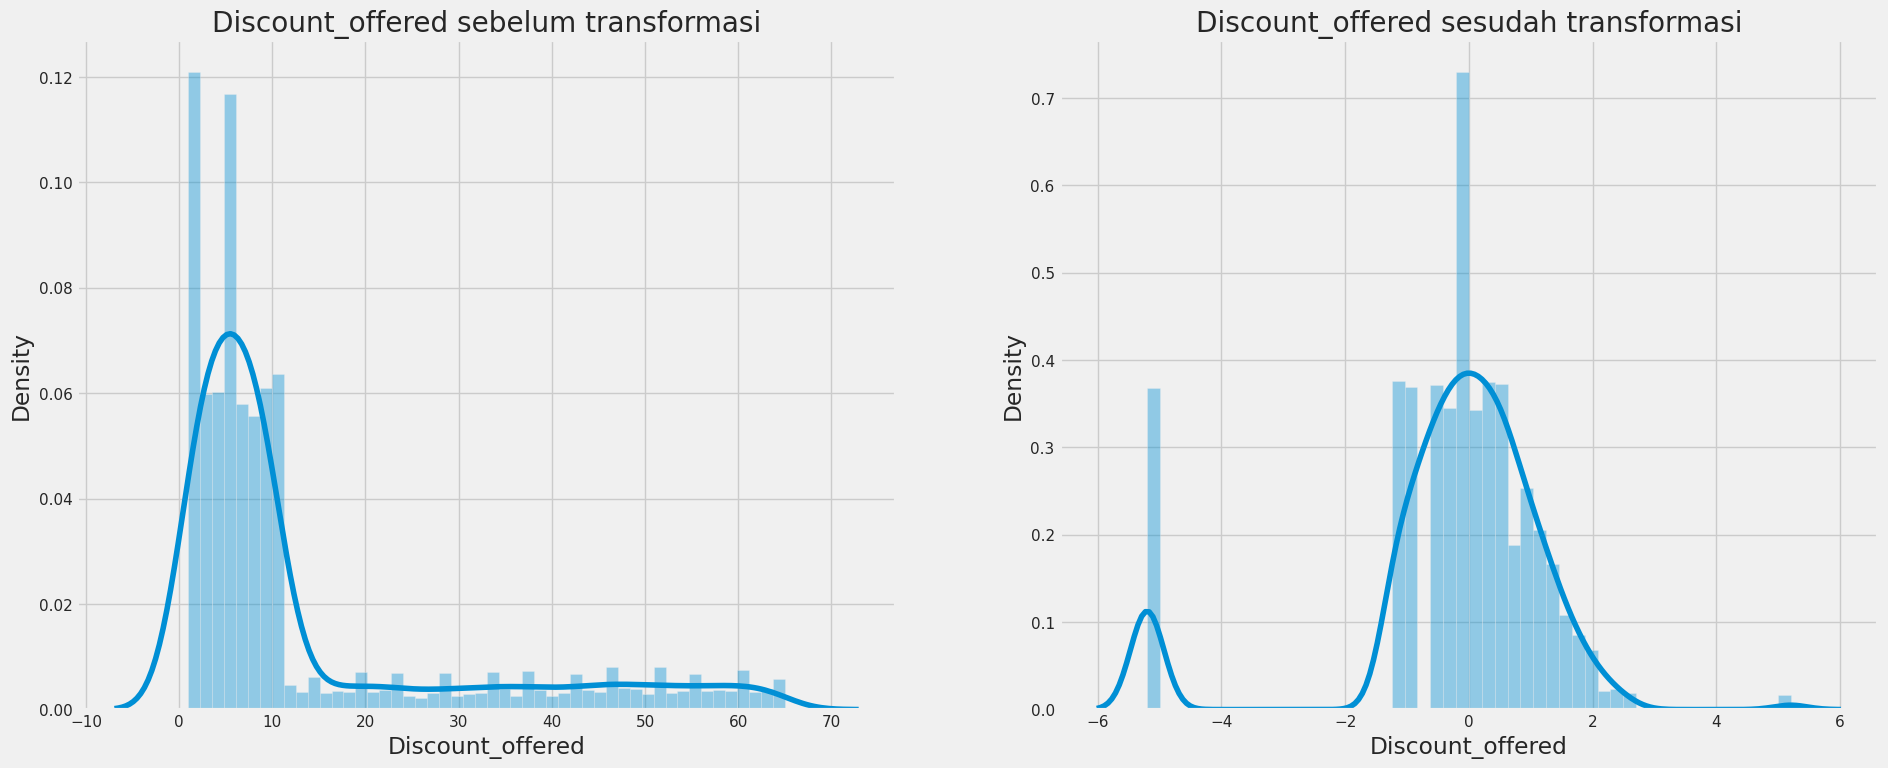

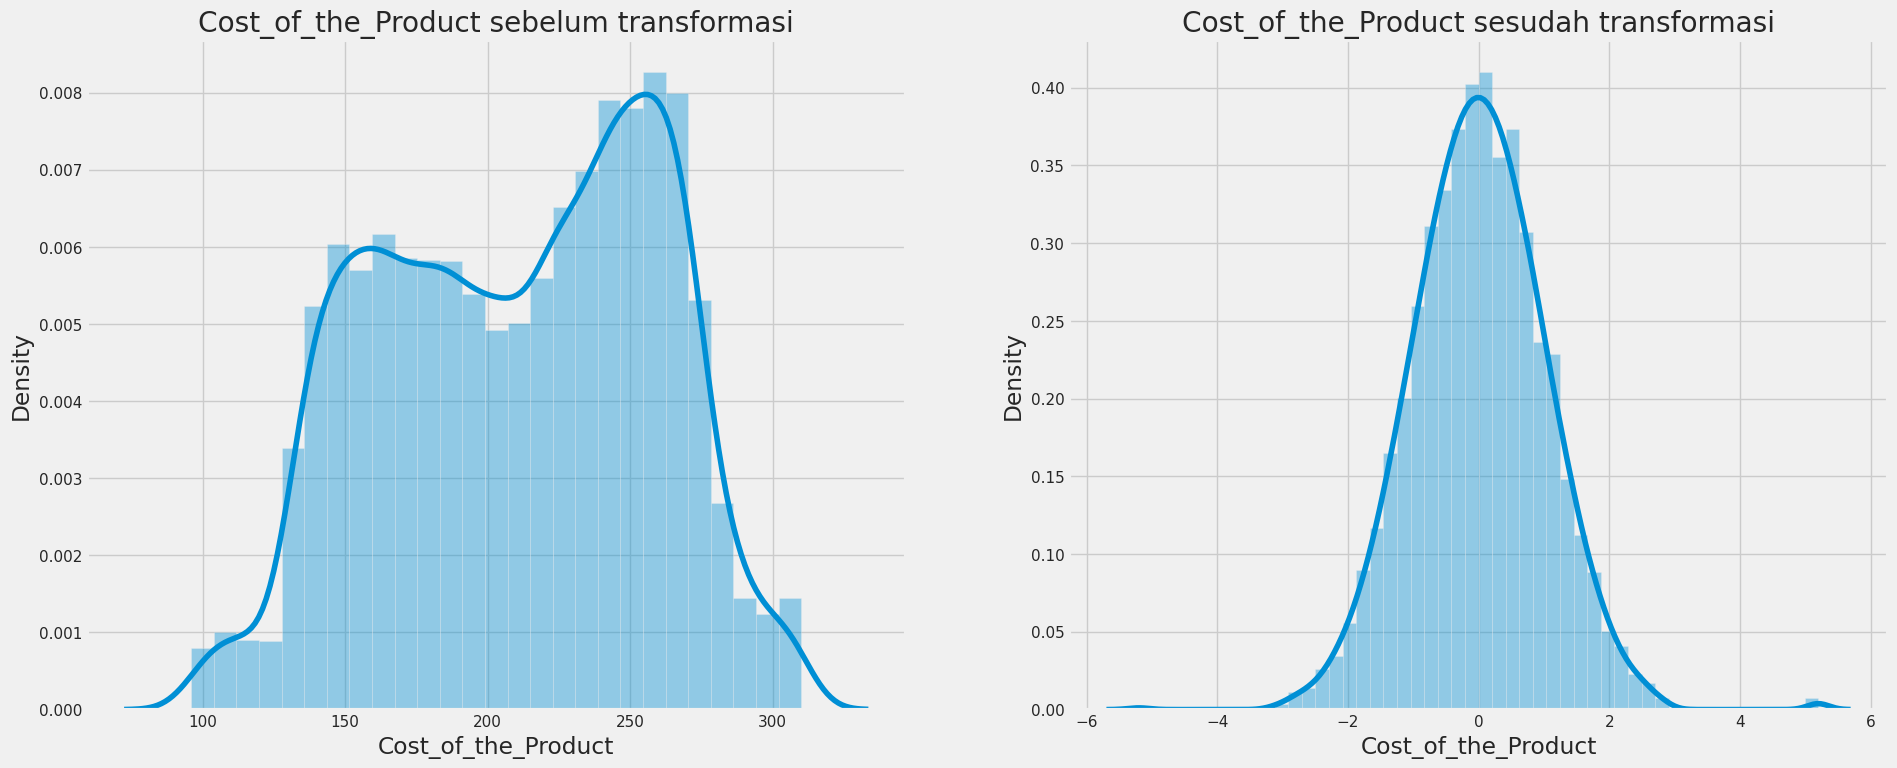

In [ ]:
X_train_transformation = pd.DataFrame(X_train_transformation,columns= numerical)

for col in list_transformation:
    plt.subplot(121)
    sns.distplot(X_train1[col])
    plt.title(f'{col} sebelum transformasi')

    plt.subplot(122)
    sns.distplot(X_train_transformation[col])
    plt.title(f'{col} sesudah transformasi')
    plt.show()

### Transformasi Data Test

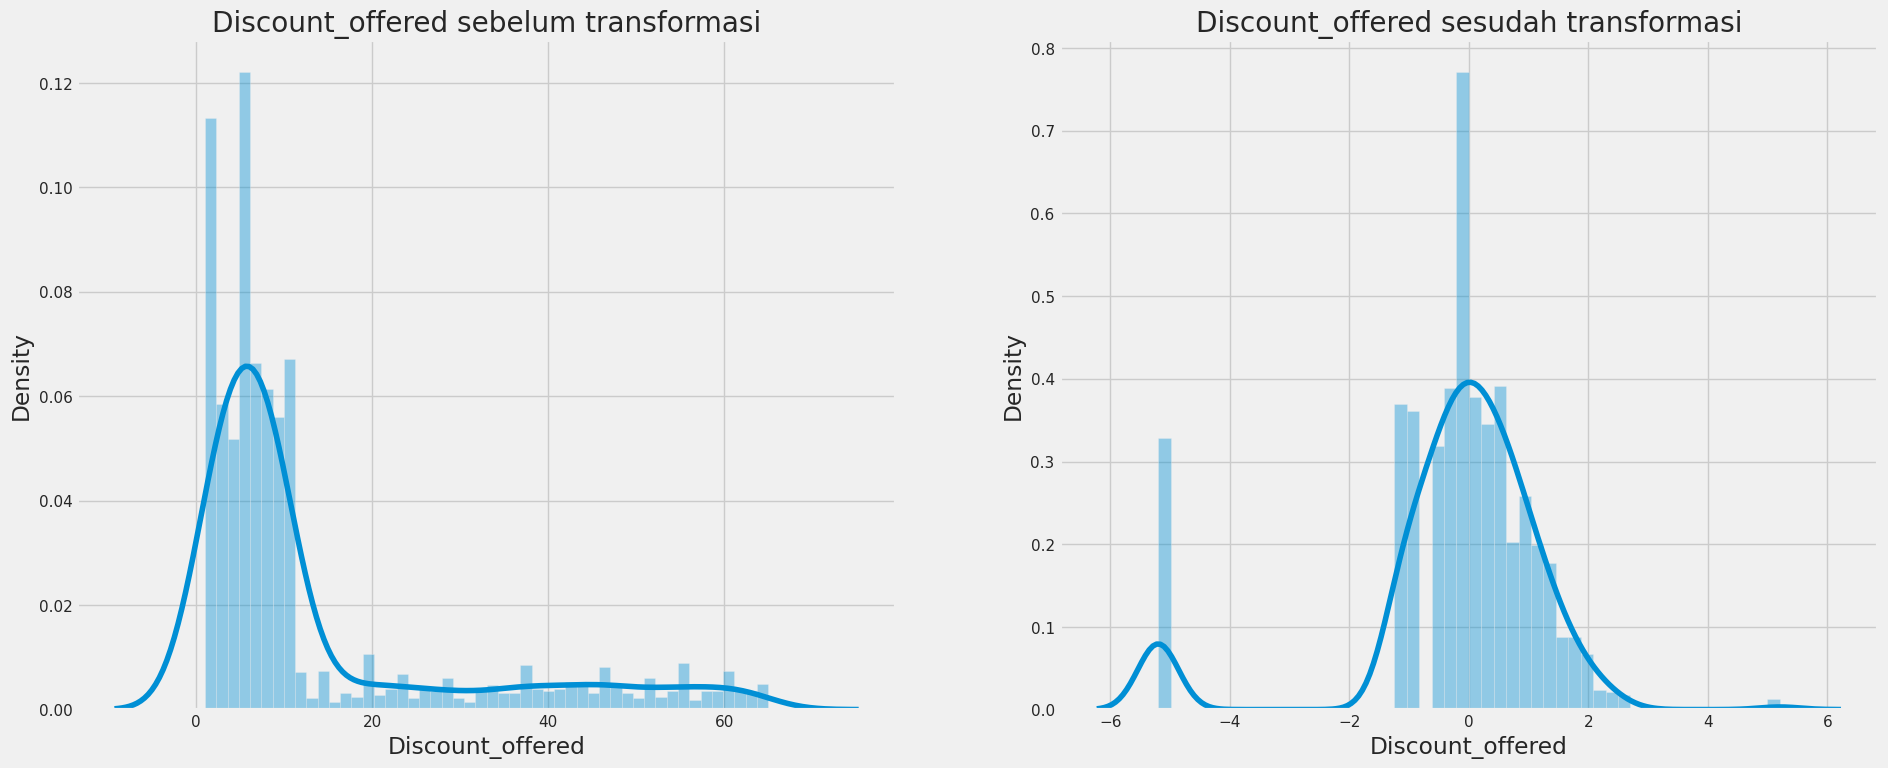

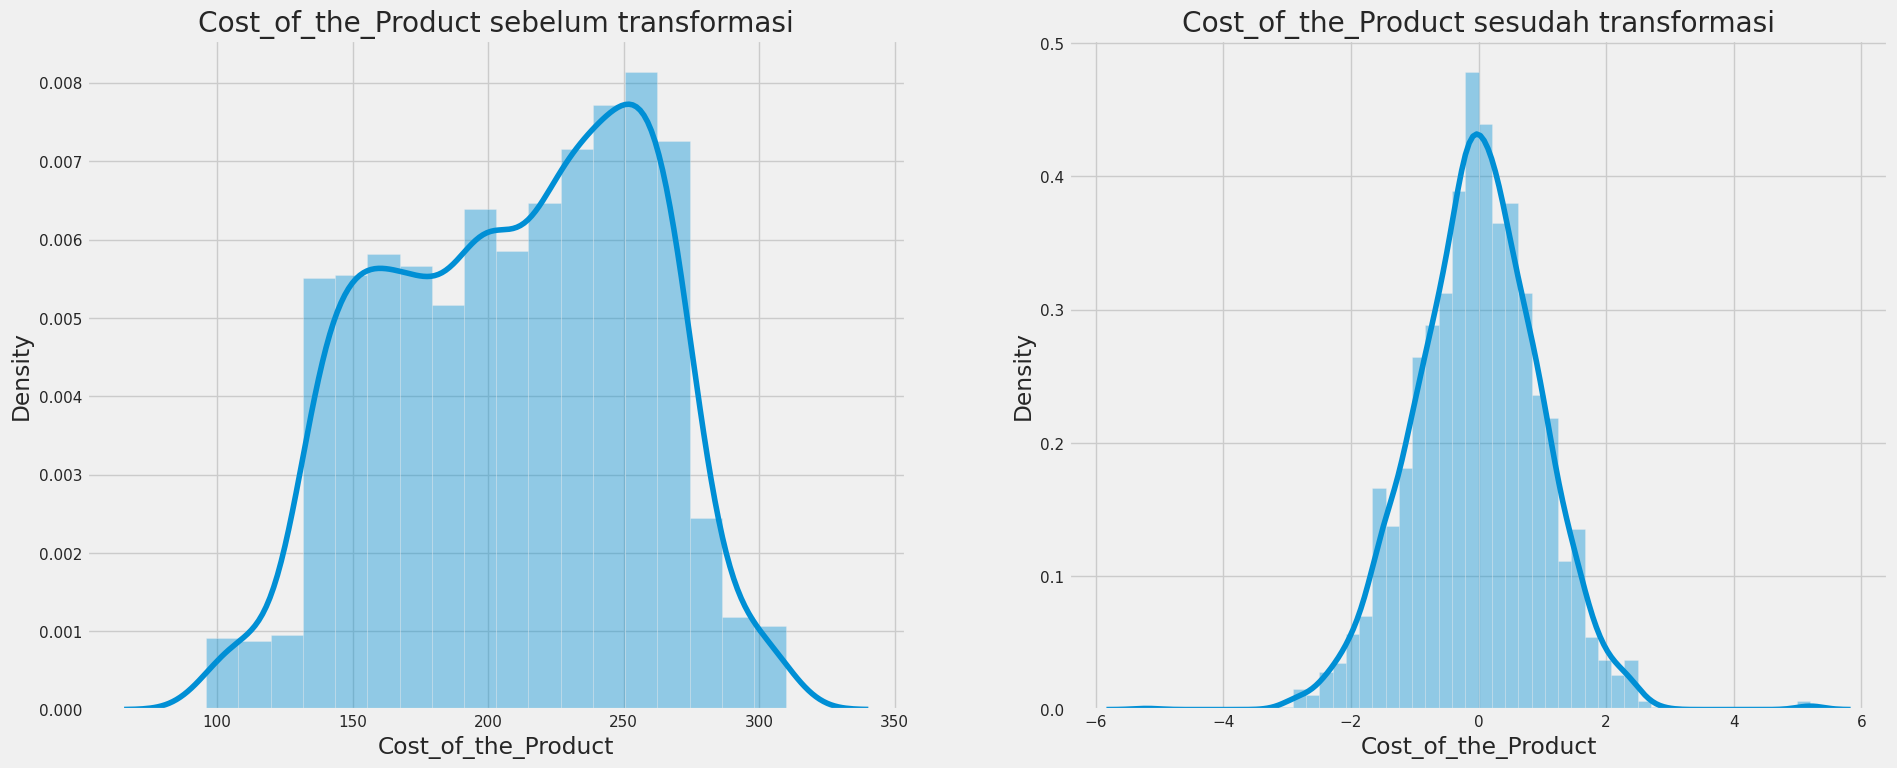

In [ ]:
X_test_transformation = pd.DataFrame(X_test_transformation,columns = numerical)


for col in list_transformation:
    plt.subplot(121)
    sns.distplot(X_test1[col])
    plt.title(f'{col} sebelum transformasi')

    plt.subplot(122)
    sns.distplot(X_test_transformation[col])
    plt.title(f'{col} sesudah transformasi')
    plt.show()

In [ ]:
# membuat fungsi untuk scaling
def scaling(data):
  scaling_data = data.copy()
  scaling_data['Discount_offered'] = scaling_Discount_offered.transform(data['Discount_offered'].values.reshape(-1, 1))
  scaling_data['Cost_of_the_Product'] = scaling_Cost_of_the_Product.transform(data['Cost_of_the_Product'].values.reshape(-1, 1))
  return scaling_data

In [ ]:
# Data Scaling menggunakan StandardScaler

scaling_Discount_offered = StandardScaler()
scaling_Cost_of_the_Product = StandardScaler()

scaling_Discount_offered.fit(X_train_transformation['Discount_offered'].values.reshape(-1, 1))
scaling_Cost_of_the_Product.fit(X_train_transformation['Cost_of_the_Product'].values.reshape(-1, 1))

X_train_scaling = scaling(X_train_transformation)
X_test_scaling = scaling(X_train_transformation)

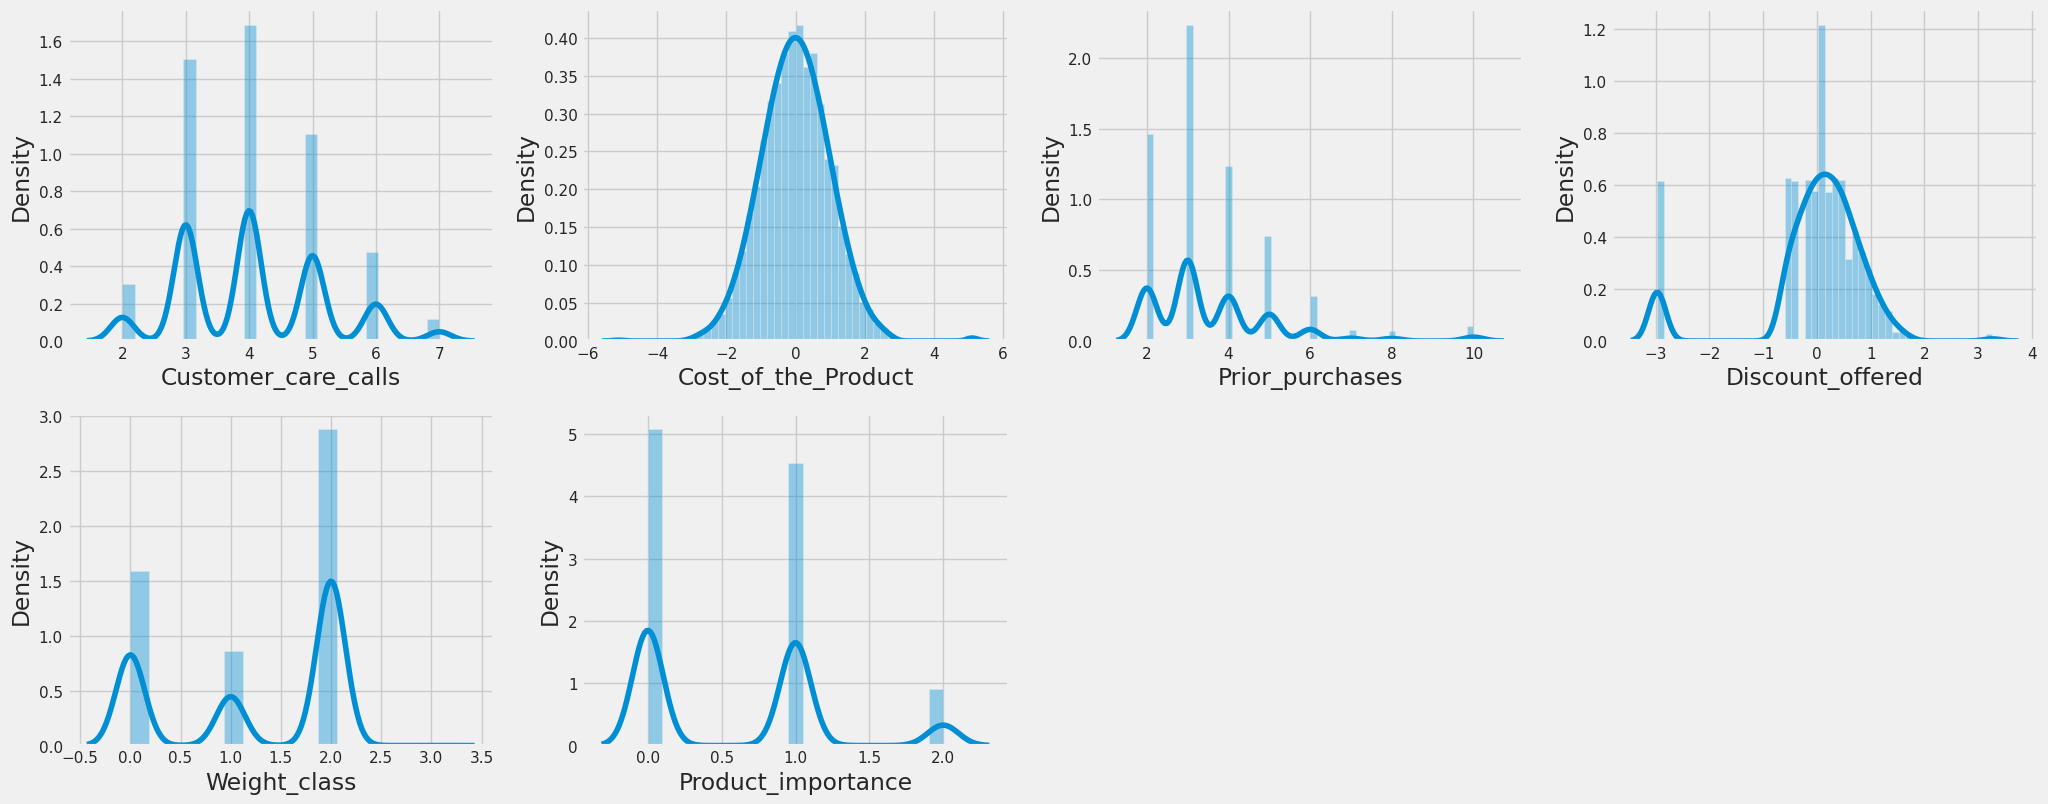

In [ ]:
# Sebaran fitur setelah dilakukan scaling

for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.distplot(X_train_scaling[numerical[i]], kde = True)
    plt.tight_layout()

# Class Imbalance

In [ ]:
percentage = round(df['Delivered_on_Time'].value_counts(normalize = True)*100,2)
print(percentage)

1    59.67
0    40.33
Name: Delivered_on_Time, dtype: float64


Dapat dilihat pada perbandingan nilai target (1: tidak terkirim tepat waktu dan 0: terkirim tepat waktu) memiliki perbandingan data 59.67: 40.33. Sehingga pada dataset ini tidak perlu dilakukan handling untuk class imbalance.

# Feature Tambahan

Feature tambahan yang berpotensi meningkatkan performansi model:
*   Tanggal Pengiriman (dapat dilakukan extraction pada tanggal (menjadi jam, hari, dll) agar didapatkan informasi tambahan terkait waktu traffic ramai, office hours, weekdays, weekend, atau waktu yang bersifat seasonal)
*   Jarak Pengiriman (untuk mengetahui estimasi waktu barang sampai)
*   Lokasi Penerima (untuk mengetahui estimasi waktu barang sampai)
*   Nama layanan ekspedisi pengiriman (misal JNE, JNT, Anteraja, dll)
*   Jenis Pengiriman (misalnya Same day delivery, Pengiriman dalam kota, Cargo, Express, Reguler, dll)





